In [ ]:
########################################################################################################################
####-------| NOTE 1.A. IMPORTS LIBRARIES | XXX -----------------------------------------------------####################
########################################################################################################################


"""Train CIFAR100 with PyTorch."""

# Python 2/3 compatibility
# from __future__ import print_function


# Standard libraries
import sys
import os
import argparse
from tqdm import tqdm
import math
import random
import numpy as np


# PyTorch and related modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

# torchvision for datasets and transforms
import torchvision
import torchvision.transforms as transforms
import torch_optimizer as torch_opt  # Use 'torch_opt' for torch_optimizer
from timm.scheduler import CosineLRScheduler 
from torch.optim.lr_scheduler import OneCycleLR





# ✅ Define currect working directory to ensure on right directory
VGG16_PATH = r"C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation"
if os.getcwd() != VGG16_PATH:
    os.chdir(VGG16_PATH)
print(f"✅ Current working directory: {os.getcwd()}")

# ✅ Define absolute paths
PROJECT_PATH = VGG16_PATH
MODELS_PATH = os.path.join(VGG16_PATH, "models")
ACTIVATION_PATH = os.path.join(VGG16_PATH, "activation")
# PAU_PATH = os.path.join(VGG16_PATH, "pau")

# ✅ Ensure necessary paths are in sys.path
for path in [PROJECT_PATH, MODELS_PATH, ACTIVATION_PATH]:
    if path not in sys.path:
        sys.path.append(path)

# ✅ Print updated sys.path for debugging
print("✅ sys.path updated:")
for path in sys.path:
    print("   📂", path)

# ✅ Import FFTGate (Check if the module exists)
try:
    from activation.FFTGate import FFTGate  # type: ignore
    print("✅ FFTGate imported successfully!")
except ModuleNotFoundError as e:
    print(f"❌ Import failed: {e}")
    print(f"🔍 Check that 'Activation4.py' exists inside: {ACTIVATION_PATH}")

# ✅ Test if FFTGate is callable
try:
    activation_test = FFTGate()
    print("✅ FFTGate instance created successfully!")
except Exception as e:
    print(f"❌ Error while initializing FFTGate: {e}")

# ✅ Now import FFTGate_VGG (Ensure module exists inside models/)
try:
    from models.FFTGate_VGG import FFTGate_VGG  # type: ignore
    print("✅ FFTGate_VGG imported successfully!")
except ModuleNotFoundError as e:
    print(f"❌ FFTGate_VGG import failed: {e}")
    print(f"🔍 Check that 'FFTGate_VGG.py' exists inside: {MODELS_PATH}")






########################################################################################################################
####-------| NOTE 1.B. SEEDING FOR REPRODUCIBILITY | XXX -------------------------------------------####################
########################################################################################################################

def set_seed_torch(seed):
    torch.manual_seed(seed)                          



def set_seed_main(seed):
    random.seed(seed)                                ## Python's random module
    np.random.seed(seed)                             ## NumPy's random module
    torch.cuda.manual_seed(seed)                     ## PyTorch's random module for CUDA
    torch.cuda.manual_seed_all(seed)                 ## Seed for all CUDA devices
    torch.backends.cudnn.deterministic = True        ## Ensure deterministic behavior for CuDNN
    torch.backends.cudnn.benchmark = False           ## Disable CuDNN's autotuning for reproducibility



# Variable seed for DataLoader shuffling
set_seed_torch(1)   

# Variable main seed (model, CUDA, etc.)
set_seed_main(2)  







# (Optional) Import Optimizers - Uncomment as needed
# from Opt import opt
# from diffGrad import diffGrad
# from diffRGrad import diffRGrad, SdiffRGrad, BetaDiffRGrad, Beta12DiffRGrad, BetaDFCDiffRGrad
# from RADAM import Radam, BetaRadam
# from BetaAdam import BetaAdam, BetaAdam1, BetaAdam2, BetaAdam3, BetaAdam4, BetaAdam5, BetaAdam6, BetaAdam7, BetaAdam4A
# from AdamRM import AdamRM, AdamRM1, AdamRM2, AdamRM3, AdamRM4, AdamRM5
# from sadam import sadam
# from SdiffGrad import SdiffGrad
# from SRADAM import SRADAM







########################################################################################################################
####-------| NOTE 2. DEFINE MODEL Lr | XXX ---------------------------------------------------------####################
########################################################################################################################

# Main Execution (Placeholder)
if __name__ == "__main__":
    print("CIFAR100 Training Script Initialized...")
    # Add your training pipeline here


import argparse
import os

# Argument parser to get user inputs
parser = argparse.ArgumentParser(description='PyTorch CIFAR100 Training')
parser.add_argument('--lr', default=0.001, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true', help='resume from checkpoint')

args, unknown = parser.parse_known_args()  # Avoids Jupyter argument issues
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Ensure lr is correctly parsed
lr = args.lr  # Get learning rate from argparse
lr_str = str(lr).replace('.', '_')  # Convert to string and replace '.' for filenames

# Debugging prints
print(f"Using device: {device}")
print(f"Parsed learning rate: {lr} (type: {type(lr)})")
print(f"Formatted learning rate for filenames: {lr_str}")

# Initialize training variables
best_acc = 0  # Best test accuracy
start_epoch = 0  # Start from epoch 0 or last checkpoint epoch







########################################################################################################################
####-------| NOTE 3. LOAD DATASET | XXX ------------------------------------------------------------####################
########################################################################################################################

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

bs = 64 #set batch size
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=0)
#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')





# ✅ Length of train and test datasets
len_train = len(trainset)
len_test = len(testset)
print(f"Length of training dataset: {len_train}")
print(f"Length of testing dataset: {len_test}")

# ✅ Print number of classes
num_classes_Print = len(trainset.classes)
print(f"Number of classes in CIFAR-100: {num_classes_Print}")







########################################################################################################################
####-------| NOTE 4. DYNAMIC REGULARIZATION| XXX ---------------------------------------------------####################
########################################################################################################################

def apply_dynamic_regularization(inputs, feature_activations, epoch,
                                  prev_params, layer_index_map, batch_idx):


    global activation_layers  # ✅ Reference already-collected layers

    # ✅ Print gamma1 stats early in training for monitoring
    if batch_idx == 0 and epoch <= 4:
        print(f"\n🚨 ENTERED apply_dynamic_regularization | Epoch={epoch} | Batch={batch_idx}", flush=True)

        # 🧠 Print gamma1 details
        all_layer_info = []
        for idx, layer in enumerate(activation_layers):
            param = getattr(layer, "gamma1")
            all_layer_info.append(f"Layer {idx}: ID={id(param)} | Mean={param.mean().item():.5f}")
        print("🧠 GAMMA1 INFO:", " | ".join(all_layer_info), flush=True)

    # ✅ Initialize gamma1 regularization accumulator
    gamma1_reg = 0.0

    # ✅ Compute batch std and define regularization strength
    batch_std = torch.std(inputs) + 1e-6
    regularization_strength = 0.05 if epoch < 40 else (0.01 if epoch < 60 else 0.005)

    # ✅ Track layers where noise is injected (informative)
    noisy_layers = []
    for idx, layer in enumerate(activation_layers):
        if idx not in layer_index_map:
            continue

        prev_layer_params = prev_params[layer_index_map[idx]]
        param_name = "gamma1"
        param = getattr(layer, param_name)
        prev_param = prev_layer_params[param_name]

        # ✅ Target based on input stats
        target = compute_target(param_name, batch_std)

        # ✅ Adaptive Target Regularization
        gamma1_reg += regularization_strength * (param - target).pow(2).mean() * 1.2

        # ✅ Adaptive Cohesion Regularization
        cohesion = (param - prev_param).pow(2)
        gamma1_reg += 0.005 * cohesion.mean()

        # ✅ Adaptive Noise Regularization
        epoch_AddNoise = 50
        if epoch > epoch_AddNoise:
            param_variation = torch.abs(param - prev_param).mean()
            if param_variation < 0.015:
                noise = (0.001 + 0.0004 * batch_std.item()) * torch.randn_like(param)
                penalty = (param - (prev_param + noise)).pow(2).sum()
                gamma1_reg += 0.00015 * penalty
                noisy_layers.append(f"{idx} (Δ={param_variation.item():.5f})") # Collect index and variation

    # ✅ Print noise injection summary
    if batch_idx == 0 and epoch <= (epoch_AddNoise + 4) and noisy_layers:
        print(f"🔥 Stable Noise Injected | Epoch {epoch} | Batch {batch_idx} | Layers: " + ", ".join(noisy_layers), flush=True)
    mags = feature_activations.abs().mean(dim=(0, 2, 3))
    m = mags / mags.sum()
    gamma1_reg += 0.005 * (-(m * torch.log(m + 1e-6)).sum())

    return gamma1_reg


def compute_target(param_name, batch_std):
    if param_name == "gamma1":
        return 2.0 + 0.2 * batch_std.item()  

    raise ValueError(f"Unknown param {param_name}")





########################################################################################################################
####-------| NOTE 5. INITIALIZE MODEL | XXX --------------------------------------------------------####################
########################################################################################################################

# Model
print('==> Building model..')
#net = Elliott_VGG('VGG16'); net1 = 'Elliott_VGG16'
#net = GELU_MobileNet(); net1 = 'GELU_MobileNet'
#net = GELU_SENet18(); net1 = 'GELU_SENet18'
#net = PDELU_ResNet50(); net1 = 'PDELU_ResNet50'
# net = Sigmoid_GoogLeNet(); net1 = 'Sigmoid_GoogLeNet'
#net = GELU_DenseNet121(); net1 = 'GELU_DenseNet121'
# net = ReLU_VGG('VGG16'); net1 = 'ReLU_VGG16'
net = FFTGate_VGG('VGG16'); net1 = 'FFTGate_VGG16'


net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9); optimizer1 = 'SGDM5'
#optimizer = optim.Adagrad(net.parameters()); optimizer1 = 'AdaGrad'
#optimizer = optim.Adadelta(net.parameters()); optimizer1 = 'AdaDelta'
#optimizer = optim.RMSprop(net.parameters()); optimizer1 = 'RMSprop'
optimizer = optim.Adam(net.parameters(), lr=args.lr); optimizer1 = 'Adam'
#optimizer = optim.Adam(net.parameters(), lr=args.lr, amsgrad=True); optimizer1 = 'amsgrad'
#optimizer = diffGrad(net.parameters(), lr=args.lr); optimizer1 = 'diffGrad'
#optimizer = Radam(net.parameters(), lr=args.lr); optimizer1 = 'Radam'







########################################################################################################################
####-------| NOTE 6. INITIALIZE ACTIVATION PARAMETERS, OPTIMIZERS & SCHEDULERS | XXX ---------------####################
########################################################################################################################

import torch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# ✅ Step 1: Collect Activation Parameters from ALL Layers (Ensure Compatibility with DataParallel)
if isinstance(net, torch.nn.DataParallel):
    features = net.module.features
else:
    features = net.features





# ✅ Step 2: Recursively search for FFTGate layers
activation_params = []
activation_layers = []

for layer in features:
    if isinstance(layer, FFTGate):  
        activation_layers.append(layer)
        activation_params.append(layer.gamma1)  # ✅ Only gamma1 is trainable





# ✅ Step 3: Define Unfreeze Epoch
unfreeze_activation_epoch = 1  # ✅ Change this value if needed
# unfreeze_activation_epoch = 10  # ✅ Delay unfreezing until epoch 10


# ✅ Define the warm-up epoch value
# WARMUP_ACTIVATION_EPOCHS = 5  # The number of epochs for warm-up
WARMUP_ACTIVATION_EPOCHS = 0  # The number of epochs for warm-up


# ✅ Step 4: Initially Freeze Activation Parameters
for param in activation_params:
    param.requires_grad = False  # 🚫 Keep frozen before the unfreeze epoch




# ✅ Step 4: Initialize Activation Optimizers (Using AdamW for Better Weight Decay)
activation_optimizers = {
    "gamma1": torch.optim.AdamW(activation_params, lr=0.0015, weight_decay=1e-6)  # 🔺 Reduce LR from 0.005 → 0.0025
}




# ✅ Step 5: Initialize Activation Schedulers with Warm Restarts (Per Parameter Type)
activation_schedulers = {
    "gamma1": CosineAnnealingWarmRestarts(
        activation_optimizers["gamma1"],
        T_0=10,      # Shorter cycle to explore aggressively
        T_mult=2,    # Increase cycle length gradually
        eta_min=5e-5  # ✅ recommended safer modification
    )
}





# ✅ Step 6: Print collected activation layers and parameters
if activation_layers and activation_params:
    print(f"✅ Found {len(activation_layers)} FFTGate layers.")
    print(f"✅ Collected {len(activation_params)} trainable activation parameters.")
    
    for idx, layer in enumerate(activation_layers):
        print(f"   🔹 Layer {idx}: {layer}")

elif activation_layers and not activation_params:
    print(f"⚠ Warning: Found {len(activation_layers)} FFTGate layers, but no trainable parameters were collected.")

elif activation_params and not activation_layers:
    print(f"⚠ Warning: Collected {len(activation_params)} activation parameters, but no FFTGate layers were recorded.")

else:
    print("⚠ Warning: No FFTGate layers or activation parameters found! Skipping activation optimizer.")
    activation_optimizers = None


########################################################################################################################
####-------| NOTE 7. INITIALIZE MAIN OPTIMIZER SCHEDULER | XXX -------------------------------------####################
########################################################################################################################

# ✅ Step 6: Define MultiStepLR for Main Optimizer
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80], gamma=0.1, last_epoch=-1)

main_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80], gamma=0.1, last_epoch=-1)






########################################################################################################################
####-------| NOTE 8. MODEL CHECK POINT | XXX -------------------------------------------------------####################
########################################################################################################################

import os
import torch

# Ensure directories exist
if not os.path.exists('checkpoint'):
    os.makedirs('checkpoint')

if not os.path.exists('Results'):
    os.makedirs('Results')

# Construct checkpoint path
checkpoint_path = f'./checkpoint/CIFAR100_B{bs}_LR{lr}_{net1}_{optimizer1}.t7'

# Resume checkpoint only if file exists
if args.resume:
    print('==> Resuming from checkpoint..')
    
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        net.load_state_dict(checkpoint['net'])
        best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch']
        print(f"Checkpoint loaded: {checkpoint_path}")
    else:
        print(f"Error: Checkpoint file not found: {checkpoint_path}")





########################################################################################################################
####-------| NOTE 9. DEFINE TRAIN LOOP | XXX -------------------------------------------------------####################
########################################################################################################################

# ✅ Used for naming files 
sinPertubation_mode = "no_sinPertubation"  # Options: "no_sinPertubation", "no_sinPertubation"

# Training

def train(epoch, optimizer, activation_optimizers, activation_schedulers, unfreeze_activation_epoch, main_scheduler , WARMUP_ACTIVATION_EPOCHS):
    global train_loss_history, best_train_acc, prev_params, recent_test_acc, gamma1_history, activation_layers, test_acc_history, train_acc_history, sinPertubation_mode  # 🟢🟢🟢

    if epoch == 0:
        train_loss_history = []
        train_acc_history = []
        best_train_acc = 0.0
        recent_test_acc = 0.0
        gamma1_history = {}         # ✅ Initialize history
        test_acc_history = []       # ✅ test accuracy history



    prev_params = {}
    layer_index_map = {idx: idx for idx in range(len(activation_layers))}  

    # ✅ Cache previous gamma1 values from activation layers
    for idx, layer in enumerate(activation_layers):
        prev_params[idx] = {
            "gamma1": layer.gamma1.clone().detach()
        }



    net.train()
    train_loss = 0
    correct = 0
    total = 0
    train_accuracy = 0.0

    # ✅ Initialize log history
    log_history = []



    # ✅ Define path to store Training log
    save_paths = {
       
        "log_history": f"C:\\Users\\emeka\\Research\\ModelCUDA\\Big_Data_Journal\\Comparison\\Code\\Paper\\github2\\AblationExperiments\\SinPertubation-No_SinPertubation\\Results\\FFTGate\\FFTGate_training_logs.txt"  # ✅ Training log_history 
    }




    # ✅ Step 1: Unfreeze Activation Parameters (Only Once Per Epoch)
    if epoch == unfreeze_activation_epoch:
        print("\n🔓 Unfreezing Activation Function Parameters 🔓")
        for layer in net.module.features if isinstance(net, torch.nn.DataParallel) else net.features:
            if isinstance(layer, FFTGate):   
                layer.gamma1.requires_grad = True  # ✅ Only gamma1 is trainable
        print("✅ Activation Parameters Unfrozen! 🚀")





    # ✅ Step 2: Gradual Warm-up for Activation Learning Rates (AFTER Unfreezing)
    warmup_start = unfreeze_activation_epoch  # 🔹 Start warm-up when unfreezing happens
    warmup_end = unfreeze_activation_epoch + WARMUP_ACTIVATION_EPOCHS  # 🔹 End warm-up period

    # ✅ Adjust learning rates **only** during the warm-up phase
    if warmup_start <= epoch < warmup_end:
        warmup_factor = (epoch - warmup_start + 1) / WARMUP_ACTIVATION_EPOCHS  

        for name, act_scheduler in activation_schedulers.items():
            for param_group in act_scheduler.optimizer.param_groups:
                if "initial_lr" not in param_group:
                    param_group["initial_lr"] = param_group["lr"]  # 🔹 Store initial LR
                param_group["lr"] = param_group["initial_lr"] * warmup_factor  # 🔹 Scale LR

        # ✅ Debugging output to track warm-up process
        print(f"🔥 Warm-up Epoch {epoch}: Scaling LR by {warmup_factor:.3f}")
        for name, act_scheduler in activation_schedulers.items():
            print(f"  🔹 {name} LR: {act_scheduler.optimizer.param_groups[0]['lr']:.6f}")






    activation_history = []  # 🔴 Initialize empty history at start of epoch (outside batch loop)



    # ✅ Training Loop
    with tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch}") as progress:
        for batch_idx, (inputs, targets) in progress:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()


            # zero_grad activation parameter
            for opt in activation_optimizers.values():
                opt.zero_grad()


            # ✅ Forward Pass
            outputs = net(inputs, epoch=epoch, train_accuracy=train_accuracy, targets=targets)
            loss = criterion(outputs, targets)

            
            feature_activations = features(inputs)  # Feature activations


            # ✅ Collect Activation History | ✅ Per-layer mean activations
            batch_means = [layer.saved_output.mean().item() for layer in activation_layers]
            activation_history.extend(batch_means)

            # ✅ Apply Decay strategy to history for each activation layer
            with torch.no_grad():
                for layer in activation_layers:
                    if isinstance(layer, FFTGate):
                        layer.decay_spectral_history(epoch, num_epochs)




            # ✅ Compute Training Accuracy
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            train_accuracy = 100. * correct / total if total > 0 else 0.0  # Compute training accuracy






            # ✅ Call Regularization Function for the Activation Parameter
            if epoch > 0:
                gamma1_reg = apply_dynamic_regularization(
                    inputs, feature_activations, epoch,
                    prev_params, layer_index_map, batch_idx
                )
                loss += gamma1_reg






            # ✅ Backward pass
            loss.backward()



            # ✅ 🎯 Adaptive Gradient Clipping of gamma1  
            for layer in features:
                if isinstance(layer, FFTGate):  # ✅ Ensure layer has gamma1 before clipping
                    torch.nn.utils.clip_grad_norm_([layer.gamma1], max_norm=0.7)
                        



            # ✅ Apply Optimizer Step for Model Parameters
            optimizer.step()

            # ✅ Apply Optimizer Steps for Activation Parameters (Only if Unfrozen)
            if epoch >= unfreeze_activation_epoch:
                for opt in activation_optimizers.values():
                    opt.step()


            # ✅ Accumulate loss
            train_loss += loss.item()



            # ✅ Clamping of gamma1 (Applied AFTER Optimizer Step)
            with torch.no_grad():
                for layer in activation_layers:
                    layer.gamma1.clamp_(0.1, 6.0)  




            # ✅ Update progress bar
            progress.set_postfix(Train_loss=round(train_loss / (batch_idx + 1), 3),
                                 Train_acc=train_accuracy)  



    # ✅ Step the main optimizer scheduler (ONLY for model parameters)
    main_scheduler.step()

    # ✅ Step the activation parameter schedulers (ONLY for activation parameters) | Epoch-wise stepping
    if epoch >= unfreeze_activation_epoch:
        for name, act_scheduler in activation_schedulers.items():  
            act_scheduler.step()  




    # ✅ ONLY update prev_params here AFTER all updates | ✅ Update prev_params AFTER training epoch
    for idx, layer in enumerate(activation_layers):      
        prev_params[idx] = {
            "gamma1": layer.gamma1.clone().detach()
        }




    # ✅ Logging Activation Parameters & Gradients
    last_batch_grads = {"Gamma1 Grad": []}
    current_params = {"Gamma1": []}

    for layer in features:
        if isinstance(layer, FFTGate):  
            # ✅ Convert gradients to scalar floats and format to 5 decimal places (removes device='cuda:0' and tensor(...))
            last_batch_grads["Gamma1 Grad"].append(f"{layer.gamma1.grad.item():.5f}" if layer.gamma1.grad is not None else "None")

            # ✅ Collect current parameter values (already scalar), formatted to 5 decimal places
            current_params["Gamma1"].append(f"{layer.gamma1.item():.5f}")

    # ✅ Build log message (showing params and gradients for ALL layers)
    log_msg = (
        f"Epoch {epoch}: M_Optimizer LR => {optimizer.param_groups[0]['lr']:.5f} | "
        f"Gamma1 LR => {activation_optimizers['gamma1'].param_groups[0]['lr']:.5f} | "
        f"Gamma1: {current_params['Gamma1']} | "
        f"Gamma1 Grad: {last_batch_grads['Gamma1 Grad']}"
    )

    log_history.append(log_msg)
    print(log_msg)  # ✅ Prints only once per epoch




    # ✅ Initialize log file at the beginning of training (Clear old logs)
    if epoch == 0:  # ✅ Only clear at the start of training
        with open(save_paths["log_history"], "w", encoding="utf-8") as log_file:
            log_file.write("")  # ✅ Clears previous logs

    # ✅ Save logs once per epoch (Append new logs)
    if log_history:
        with open(save_paths["log_history"], "a", encoding="utf-8") as log_file:
            log_file.write("\n".join(log_history) + "\n")         # ✅ Ensure each entry is on a new line
        print(f"📜 Logs saved to {save_paths['log_history']}!")  # ✅ Only prints once per epoch
    else:
        print("⚠ No logs to save!")




    # ✅ Compute final training accuracy for the epoch
    final_train_loss = train_loss / len(trainloader)
    final_train_acc = 100. * correct / total

    # ✅ Append to history
    train_loss_history.append(final_train_loss)

    # Append per-epoch training accuracy
    train_acc_history.append(final_train_acc)




    # ✅ Save training results (without affecting best accuracy tracking)
    train_results_path = f'./Results/CIFAR100_Train_{sinPertubation_mode}_B{bs}_LR{lr}_{net1}_{optimizer1}.txt'

    # ✅ Clear the log file at the start of training (Epoch 0)
    if epoch == 0 and os.path.exists(train_results_path):
        with open(train_results_path, 'w') as f:
            f.write("")  # ✅ Clears previous logs only once

    # ✅ Append new training results for each epoch
    with open(train_results_path, 'a') as f:
        f.write(f"Epoch {epoch} | Train Loss: {final_train_loss:.3f} | Train Acc: {final_train_acc:.3f}%\n")

    if final_train_acc > best_train_acc:
        best_train_acc = final_train_acc  # ✅ Update best training accuracy
        print(f"🏆 New Best Training Accuracy: {best_train_acc:.3f}% (Updated)")

    # ✅ Append the best training accuracy **only once at the end of training**
    if epoch == (num_epochs - 1):  # Only log once at the final epoch
        with open(train_results_path, 'a') as f:
            f.write(f"\n🏆 Best Training Accuracy: {best_train_acc:.3f}%\n")  

    # ✅ Print both Final and Best Training Accuracy
    print(f"📊 Train Accuracy: {final_train_acc:.3f}% | 🏆 Best Train Accuracy: {best_train_acc:.3f}%")




    print(f"📜 Training logs saved to {train_results_path}!")
    print(f"🏆 Best Training Accuracy: {best_train_acc:.3f}% (Updated)")



    if epoch % 10 == 0:
        print(f"📏 Sizes → ActivationHist: {len(activation_history)} | TestAccHist: {len(test_acc_history)} | TrainLossHist: {len(train_loss_history)}")



    # return final_train_loss, final_train_acc, feature_activations













########################################################################################################################
####-------| NOTE 10. DEFINE TEST LOOP | XXX --------------------------------------------------------####################
########################################################################################################################


import os
import torch
from tqdm import tqdm

def test(epoch, save_results=True):
    """
    Evaluates the model on the test set and optionally saves the results.
    
    Args:
    - epoch (int): The current epoch number.
    - save_results (bool): Whether to save results to a file.

    Returns:
    - acc (float): Test accuracy percentage.
    """
    global best_acc, val_accuracy, sinPertubation_mode  
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    # ✅ Ensure activation function parameters are clamped before evaluation
    with torch.no_grad():
        with tqdm(enumerate(testloader), total=len(testloader), desc=f"Testing Epoch {epoch}") as progress:
            for batch_idx, (inputs, targets) in progress:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # ✅ Pass validation accuracy to activation function
                val_accuracy = 100. * correct / total if total > 0 else 0


                # ✅ Update progress bar with loss & accuracy
                progress.set_postfix(Test_loss=round(test_loss / (batch_idx + 1), 3),
                                     Test_acc=round(val_accuracy, 3))



    # ✅ Compute final test accuracy
    final_test_loss = test_loss / len(testloader)
    final_test_acc = 100. * correct / total






    # ✅ Ensure "Results" folder exists (just like training logs)
    results_dir = os.path.join(PROJECT_PATH, "Results")
    os.makedirs(results_dir, exist_ok=True)

    # ✅ Define log file path for test results
    test_results_path = os.path.join(results_dir, f'CIFAR100_Test_{sinPertubation_mode}_B{bs}_LR{lr}_{net1}_{optimizer1}.txt')

    # ✅ Initialize log file at the beginning of training (clear old logs)
    if epoch == 0:
        with open(test_results_path, 'w', encoding="utf-8") as f:
            f.write("")  # ✅ Clears previous logs

    # ✅ Append new test results for each epoch (same style as training)
    with open(test_results_path, 'a', encoding="utf-8") as f:
        f.write(f"Epoch {epoch} | Test Loss: {final_test_loss:.3f} | Test Acc: {final_test_acc:.3f}%\n")







    # ✅ Save checkpoint if accuracy improves (does NOT interfere with logging)
    if final_test_acc > best_acc:
        print('🏆 Saving best model...')
        state = {
            'net': net.state_dict(),
            'acc': final_test_acc,  # ✅ Ensures the best test accuracy is saved in checkpoint
            'epoch': epoch,
        }




        # Ensure checkpoint directory exists
        checkpoint_dir = "checkpoint"
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)


        # ✅ Format learning rate properly before saving filename
        lr_str = str(lr).replace('.', '_')
        checkpoint_path = f'./checkpoint/CIFAR100_B{bs}_LR{lr_str}_{net1}_{optimizer1}.t7'
        torch.save(state, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")


        best_acc = final_test_acc  # ✅ Update best accuracy




    # ✅ Append the best test accuracy **only once at the end of training**
    if epoch == (num_epochs - 1):
        with open(test_results_path, 'a', encoding="utf-8") as f:
            f.write(f"\n🏆 Best Test Accuracy: {best_acc:.3f}%\n")



    # ✅ Print both Final and Best Test Accuracy (always executed)
    print(f"📊 Test Accuracy: {final_test_acc:.3f}% | 🏆 Best Test Accuracy: {best_acc:.3f}%")
    print(f"📜 Test logs saved to {test_results_path}!")


    global recent_test_acc
    recent_test_acc = final_test_acc  # Capture latest test accuracy for next train() call | Store latest test accuracy

    test_acc_history.append(final_test_acc)

    return final_test_acc  # ✅ Return the test accuracy

✅ Current working directory: C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation
✅ sys.path updated:
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\python310.zip
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\DLLs
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env
   📂 
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages\win32
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages\win32\lib
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages\Pythonwin
   📂 C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation
   📂 C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\models
   📂 C:\Users\emeka\Research\

In [ ]:
########################################################################################################################
####-------| NOTE 11. TRAIN MODEL WITH SHEDULAR | XXX ----------------------------------------------####################
########################################################################################################################



# ✅ Set Seed for Reproducibility BEFORE training starts

# Variable seed for DataLoader shuffling
set_seed_torch(1)  

# Variable main seed (model, CUDA, etc.)
set_seed_main(2)  

# ✅ Training Loop
num_epochs = 100 # Example: Set the total number of epochs
for epoch in range(start_epoch, num_epochs):   # Runs training for 100 epochs

    train(epoch, optimizer, activation_optimizers, activation_schedulers, unfreeze_activation_epoch, main_scheduler, WARMUP_ACTIVATION_EPOCHS) # ✅ Pass required arguments

    test(epoch)  # ✅ Test the model
    tqdm.write("")  # ✅ Clear leftover progress bar from test()


print("Best Test Accuracy: ", best_acc)

Epoch 0: 100%|██████████| 782/782 [00:23<00:00, 32.60it/s, Train_acc=3.47, Train_loss=4.35]


Epoch 0: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000'] | Gamma1 Grad: ['None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 3.468% (Updated)
📊 Train Accuracy: 3.468% | 🏆 Best Train Accuracy: 3.468%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 3.468% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 0 | TrainLossHist: 1


Testing Epoch 0: 100%|██████████| 157/157 [00:01<00:00, 84.35it/s, Test_acc=5.27, Test_loss=4.05]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 5.270% | 🏆 Best Test Accuracy: 5.270%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!


🔓 Unfreezing Activation Function Parameters 🔓
✅ Activation Parameters Unfrozen! 🚀


Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=1 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=2127360493264 | Mean=1.50000 | Layer 1: ID=2127360542816 | Mean=1.50000 | Layer 2: ID=2127328825152 | Mean=1.50000 | Layer 3: ID=2127328824192 | Mean=1.50000 | Layer 4: ID=2127328823312 | Mean=1.50000 | Layer 5: ID=2127328822192 | Mean=1.50000 | Layer 6: ID=2127328827472 | Mean=1.50000 | Layer 7: ID=2128028320448 | Mean=1.50000 | Layer 8: ID=2128028321408 | Mean=1.50000 | Layer 9: ID=2128028322368 | Mean=1.50000 | Layer 10: ID=2128028323328 | Mean=1.50000 | Layer 11: ID=2128028324288 | Mean=1.50000 | Layer 12: ID=2128028325248 | Mean=1.50000


Epoch 1: 100%|██████████| 782/782 [00:32<00:00, 23.99it/s, Train_acc=6.92, Train_loss=4.07]


Epoch 1: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.23146', '2.23244', '2.23102', '2.22755', '2.22775', '2.22656', '2.22698', '2.22599', '2.22641', '2.22818', '2.22363', '2.22026', '2.21007'] | Gamma1 Grad: ['0.00163', '-0.01197', '-0.00168', '-0.00619', '-0.00587', '-0.00996', '-0.00767', '-0.00325', '-0.01600', '-0.00704', '-0.00754', '-0.02460', '-0.01083']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 6.918% (Updated)
📊 Train Accuracy: 6.918% | 🏆 Best Train Accuracy: 6.918%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 6.918% (Updated)


Testing Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 88.23it/s, Test_acc=7.97, Test_loss=3.85]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 7.970% | 🏆 Best Test Accuracy: 7.970%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=2 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=2127360493264 | Mean=2.23146 | Layer 1: ID=2127360542816 | Mean=2.23244 | Layer 2: ID=2127328825152 | Mean=2.23102 | Layer 3: ID=2127328824192 | Mean=2.22755 | Layer 4: ID=2127328823312 | Mean=2.22775 | Layer 5: ID=2127328822192 | Mean=2.22656 | Layer 6: ID=2127328827472 | Mean=2.22698 | Layer 7: ID=2128028320448 | Mean=2.22599 | Layer 8: ID=2128028321408 | Mean=2.22641 | Layer 9: ID=2128028322368 | Mean=2.22818 | Layer 10: ID=2128028323328 | Mean=2.22363 | Layer 11: ID=2128028324288 | Mean=2.22026 | Layer 12: ID=2128028325248 | Mean=2.21007


Epoch 2: 100%|██████████| 782/782 [00:33<00:00, 23.62it/s, Train_acc=11.2, Train_loss=3.65]


Epoch 2: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00136 | Gamma1: ['2.29563', '2.29630', '2.29553', '2.28382', '2.28377', '2.28173', '2.28043', '2.28325', '2.27989', '2.28056', '2.27821', '2.27558', '2.25993'] | Gamma1 Grad: ['-0.03168', '-0.00290', '0.00642', '-0.00696', '-0.00122', '-0.00377', '0.00352', '-0.00089', '0.00276', '-0.00017', '0.00099', '-0.00320', '-0.00047']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 11.236% (Updated)
📊 Train Accuracy: 11.236% | 🏆 Best Train Accuracy: 11.236%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 11.236% (Updated)


Testing Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 86.24it/s, Test_acc=12.9, Test_loss=3.52]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 12.940% | 🏆 Best Test Accuracy: 12.940%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=3 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=2127360493264 | Mean=2.29563 | Layer 1: ID=2127360542816 | Mean=2.29630 | Layer 2: ID=2127328825152 | Mean=2.29553 | Layer 3: ID=2127328824192 | Mean=2.28382 | Layer 4: ID=2127328823312 | Mean=2.28377 | Layer 5: ID=2127328822192 | Mean=2.28173 | Layer 6: ID=2127328827472 | Mean=2.28043 | Layer 7: ID=2128028320448 | Mean=2.28325 | Layer 8: ID=2128028321408 | Mean=2.27989 | Layer 9: ID=2128028322368 | Mean=2.28056 | Layer 10: ID=2128028323328 | Mean=2.27821 | Layer 11: ID=2128028324288 | Mean=2.27558 | Layer 12: ID=2128028325248 | Mean=2.25993


Epoch 3: 100%|██████████| 782/782 [00:31<00:00, 24.65it/s, Train_acc=15.3, Train_loss=3.38]


Epoch 3: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00120 | Gamma1: ['2.30678', '2.30954', '2.30508', '2.29452', '2.29356', '2.29246', '2.29170', '2.29017', '2.29063', '2.28886', '2.28829', '2.28348', '2.28376'] | Gamma1 Grad: ['-0.02631', '0.00666', '0.00530', '-0.00202', '0.00902', '-0.00830', '-0.00685', '-0.00839', '-0.00526', '-0.01156', '-0.02149', '-0.04896', '-0.03622']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 15.308% (Updated)
📊 Train Accuracy: 15.308% | 🏆 Best Train Accuracy: 15.308%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 15.308% (Updated)


Testing Epoch 3: 100%|██████████| 157/157 [00:01<00:00, 89.96it/s, Test_acc=18.8, Test_loss=3.19]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 18.790% | 🏆 Best Test Accuracy: 18.790%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=4 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=2127360493264 | Mean=2.30678 | Layer 1: ID=2127360542816 | Mean=2.30954 | Layer 2: ID=2127328825152 | Mean=2.30508 | Layer 3: ID=2127328824192 | Mean=2.29452 | Layer 4: ID=2127328823312 | Mean=2.29356 | Layer 5: ID=2127328822192 | Mean=2.29246 | Layer 6: ID=2127328827472 | Mean=2.29170 | Layer 7: ID=2128028320448 | Mean=2.29017 | Layer 8: ID=2128028321408 | Mean=2.29063 | Layer 9: ID=2128028322368 | Mean=2.28886 | Layer 10: ID=2128028323328 | Mean=2.28829 | Layer 11: ID=2128028324288 | Mean=2.28348 | Layer 12: ID=2128028325248 | Mean=2.28376


Epoch 4: 100%|██████████| 782/782 [00:33<00:00, 23.66it/s, Train_acc=18.9, Train_loss=3.17]


Epoch 4: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00100 | Gamma1: ['2.30767', '2.31467', '2.29648', '2.29814', '2.29627', '2.29757', '2.29487', '2.29244', '2.29502', '2.29342', '2.29307', '2.28495', '2.28134'] | Gamma1 Grad: ['0.00275', '-0.00357', '0.01833', '0.00010', '0.01075', '0.00303', '-0.00197', '0.00695', '-0.00230', '0.00835', '-0.00266', '0.00343', '0.03427']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 18.910% (Updated)
📊 Train Accuracy: 18.910% | 🏆 Best Train Accuracy: 18.910%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 18.910% (Updated)


Testing Epoch 4: 100%|██████████| 157/157 [00:01<00:00, 87.96it/s, Test_acc=21.8, Test_loss=2.99]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 21.800% | 🏆 Best Test Accuracy: 21.800%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 5: 100%|██████████| 782/782 [00:32<00:00, 24.30it/s, Train_acc=23.2, Train_loss=2.95]


Epoch 5: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00078 | Gamma1: ['2.31964', '2.32035', '2.30908', '2.30085', '2.29983', '2.29701', '2.29220', '2.29584', '2.29237', '2.29126', '2.29175', '2.28566', '2.28012'] | Gamma1 Grad: ['-0.00169', '0.01128', '0.00566', '-0.00557', '-0.01439', '0.00598', '0.01323', '0.00402', '0.00225', '0.00334', '0.01306', '0.00563', '-0.02012']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 23.244% (Updated)
📊 Train Accuracy: 23.244% | 🏆 Best Train Accuracy: 23.244%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 23.244% (Updated)


Testing Epoch 5: 100%|██████████| 157/157 [00:01<00:00, 83.26it/s, Test_acc=26.5, Test_loss=2.76]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 26.480% | 🏆 Best Test Accuracy: 26.480%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 6: 100%|██████████| 782/782 [00:32<00:00, 24.14it/s, Train_acc=27.5, Train_loss=2.73]


Epoch 6: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00055 | Gamma1: ['2.32416', '2.32425', '2.30423', '2.29431', '2.30371', '2.29706', '2.29404', '2.29373', '2.29168', '2.29085', '2.29021', '2.28901', '2.28375'] | Gamma1 Grad: ['-0.02106', '-0.02698', '-0.00018', '-0.00508', '-0.00214', '-0.00225', '-0.00119', '-0.00069', '-0.00423', '0.00359', '0.00445', '-0.01774', '0.01124']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 27.536% (Updated)
📊 Train Accuracy: 27.536% | 🏆 Best Train Accuracy: 27.536%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 27.536% (Updated)


Testing Epoch 6: 100%|██████████| 157/157 [00:01<00:00, 90.40it/s, Test_acc=27.9, Test_loss=2.73]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 27.860% | 🏆 Best Test Accuracy: 27.860%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 7: 100%|██████████| 782/782 [00:32<00:00, 23.95it/s, Train_acc=32.4, Train_loss=2.52]


Epoch 7: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00035 | Gamma1: ['2.31486', '2.31402', '2.30515', '2.29368', '2.29879', '2.30046', '2.29262', '2.29570', '2.29195', '2.28844', '2.28548', '2.28478', '2.28760'] | Gamma1 Grad: ['-0.01125', '0.00381', '-0.00367', '-0.00029', '-0.00382', '-0.00575', '-0.00538', '0.00291', '-0.01134', '-0.01735', '-0.00891', '-0.03400', '0.06458']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 32.398% (Updated)
📊 Train Accuracy: 32.398% | 🏆 Best Train Accuracy: 32.398%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 32.398% (Updated)


Testing Epoch 7: 100%|██████████| 157/157 [00:01<00:00, 88.03it/s, Test_acc=35.3, Test_loss=2.39]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 35.270% | 🏆 Best Test Accuracy: 35.270%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 8: 100%|██████████| 782/782 [00:32<00:00, 24.22it/s, Train_acc=36.5, Train_loss=2.35]


Epoch 8: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00019 | Gamma1: ['2.31146', '2.32683', '2.31005', '2.29775', '2.29575', '2.29653', '2.29167', '2.29737', '2.29804', '2.29969', '2.29666', '2.28343', '2.29309'] | Gamma1 Grad: ['0.00059', '-0.00650', '-0.02160', '0.00102', '0.01365', '0.00406', '0.00693', '0.00050', '-0.00214', '0.00113', '-0.00005', '0.00106', '0.02706']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 36.498% (Updated)
📊 Train Accuracy: 36.498% | 🏆 Best Train Accuracy: 36.498%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 36.498% (Updated)


Testing Epoch 8: 100%|██████████| 157/157 [00:01<00:00, 84.42it/s, Test_acc=36.7, Test_loss=2.29]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 36.660% | 🏆 Best Test Accuracy: 36.660%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 9: 100%|██████████| 782/782 [00:31<00:00, 24.66it/s, Train_acc=39.8, Train_loss=2.21]


Epoch 9: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00009 | Gamma1: ['2.32212', '2.32421', '2.31204', '2.29345', '2.29895', '2.29404', '2.29149', '2.30182', '2.29743', '2.30086', '2.29781', '2.27970', '2.29877'] | Gamma1 Grad: ['-0.02836', '-0.02659', '0.00119', '-0.02045', '0.00442', '0.01982', '0.00370', '-0.00212', '-0.00104', '0.00044', '0.00068', '-0.00425', '0.01225']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 39.766% (Updated)
📊 Train Accuracy: 39.766% | 🏆 Best Train Accuracy: 39.766%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 39.766% (Updated)


Testing Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 88.33it/s, Test_acc=43, Test_loss=2.04]  


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 43.040% | 🏆 Best Test Accuracy: 43.040%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 10: 100%|██████████| 782/782 [00:31<00:00, 24.72it/s, Train_acc=43.2, Train_loss=2.07]


Epoch 10: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.32282', '2.32150', '2.30924', '2.29468', '2.30007', '2.30376', '2.29473', '2.30074', '2.29497', '2.29573', '2.29791', '2.28608', '2.29638'] | Gamma1 Grad: ['-0.02302', '-0.00908', '-0.04815', '-0.02886', '-0.00751', '-0.00420', '0.00498', '0.00774', '0.01136', '0.00924', '0.00445', '-0.00769', '-0.00825']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 43.222% (Updated)
📊 Train Accuracy: 43.222% | 🏆 Best Train Accuracy: 43.222%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 43.222% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 10 | TrainLossHist: 11


Testing Epoch 10: 100%|██████████| 157/157 [00:01<00:00, 84.45it/s, Test_acc=42.6, Test_loss=2.1] 


📊 Test Accuracy: 42.600% | 🏆 Best Test Accuracy: 43.040%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 11: 100%|██████████| 782/782 [00:32<00:00, 23.74it/s, Train_acc=46.1, Train_loss=1.94]


Epoch 11: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.31425', '2.31421', '2.32303', '2.30402', '2.30098', '2.29720', '2.29538', '2.29841', '2.30044', '2.29782', '2.29177', '2.27575', '2.29852'] | Gamma1 Grad: ['-0.00607', '0.02293', '-0.05030', '0.02227', '-0.03403', '-0.00430', '0.01624', '0.00418', '0.01182', '0.01577', '0.01069', '-0.02906', '0.05024']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 46.074% (Updated)
📊 Train Accuracy: 46.074% | 🏆 Best Train Accuracy: 46.074%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 46.074% (Updated)


Testing Epoch 11: 100%|██████████| 157/157 [00:01<00:00, 88.19it/s, Test_acc=46.9, Test_loss=1.9] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 46.870% | 🏆 Best Test Accuracy: 46.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 12: 100%|██████████| 782/782 [00:31<00:00, 24.45it/s, Train_acc=48.3, Train_loss=1.85]


Epoch 12: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.30493', '2.31588', '2.31444', '2.29673', '2.31026', '2.30358', '2.29101', '2.30364', '2.29517', '2.29080', '2.28658', '2.28423', '2.30169'] | Gamma1 Grad: ['0.00591', '0.01218', '-0.00155', '-0.01016', '-0.00479', '-0.01093', '-0.00645', '-0.00238', '-0.01705', '-0.00710', '-0.00130', '-0.00499', '0.07167']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 48.314% (Updated)
📊 Train Accuracy: 48.314% | 🏆 Best Train Accuracy: 48.314%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 48.314% (Updated)


Testing Epoch 12: 100%|██████████| 157/157 [00:01<00:00, 87.95it/s, Test_acc=47.2, Test_loss=1.89]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 47.210% | 🏆 Best Test Accuracy: 47.210%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 13: 100%|██████████| 782/782 [00:32<00:00, 24.21it/s, Train_acc=51.1, Train_loss=1.76]


Epoch 13: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00142 | Gamma1: ['2.31746', '2.32333', '2.31146', '2.29182', '2.29519', '2.30298', '2.29198', '2.29790', '2.30074', '2.29117', '2.29050', '2.28624', '2.30384'] | Gamma1 Grad: ['0.02046', '0.01882', '-0.01973', '0.04581', '0.01233', '0.00718', '0.00487', '-0.00324', '-0.00484', '-0.00518', '0.00176', '0.02322', '0.02397']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 51.064% (Updated)
📊 Train Accuracy: 51.064% | 🏆 Best Train Accuracy: 51.064%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 51.064% (Updated)


Testing Epoch 13: 100%|██████████| 157/157 [00:01<00:00, 83.89it/s, Test_acc=50.4, Test_loss=1.76]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 50.360% | 🏆 Best Test Accuracy: 50.360%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 14: 100%|██████████| 782/782 [00:32<00:00, 24.22it/s, Train_acc=52.7, Train_loss=1.68]


Epoch 14: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00136 | Gamma1: ['2.29935', '2.31970', '2.30518', '2.28672', '2.29419', '2.31003', '2.29173', '2.29666', '2.29652', '2.29728', '2.29190', '2.28979', '2.29015'] | Gamma1 Grad: ['0.01196', '-0.00108', '0.01767', '-0.00919', '-0.01377', '-0.01721', '-0.00314', '-0.00419', '0.00976', '-0.01244', '-0.01169', '0.02673', '-0.01723']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 52.658% (Updated)
📊 Train Accuracy: 52.658% | 🏆 Best Train Accuracy: 52.658%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 52.658% (Updated)


Testing Epoch 14: 100%|██████████| 157/157 [00:01<00:00, 84.06it/s, Test_acc=51.2, Test_loss=1.72]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 51.240% | 🏆 Best Test Accuracy: 51.240%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 15: 100%|██████████| 782/782 [00:31<00:00, 24.67it/s, Train_acc=54.5, Train_loss=1.6] 


Epoch 15: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00129 | Gamma1: ['2.30256', '2.31298', '2.30607', '2.30227', '2.29331', '2.29888', '2.29701', '2.30916', '2.29218', '2.28844', '2.30149', '2.28222', '2.29009'] | Gamma1 Grad: ['0.02216', '0.01595', '0.00737', '-0.00388', '-0.02429', '-0.00303', '0.00267', '-0.00368', '0.01228', '0.01353', '0.01461', '0.00536', '0.03785']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 54.526% (Updated)
📊 Train Accuracy: 54.526% | 🏆 Best Train Accuracy: 54.526%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 54.526% (Updated)


Testing Epoch 15: 100%|██████████| 157/157 [00:01<00:00, 90.92it/s, Test_acc=52.7, Test_loss=1.7] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 52.690% | 🏆 Best Test Accuracy: 52.690%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 16: 100%|██████████| 782/782 [00:35<00:00, 21.72it/s, Train_acc=56.4, Train_loss=1.54]


Epoch 16: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00120 | Gamma1: ['2.29803', '2.31970', '2.30353', '2.29487', '2.29711', '2.30323', '2.27723', '2.29304', '2.28531', '2.28689', '2.28412', '2.29535', '2.30016'] | Gamma1 Grad: ['0.01801', '-0.00951', '0.03132', '-0.00785', '-0.01877', '-0.01618', '-0.00946', '0.00524', '-0.00782', '-0.00415', '0.00059', '0.01259', '0.00812']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 56.410% (Updated)
📊 Train Accuracy: 56.410% | 🏆 Best Train Accuracy: 56.410%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 56.410% (Updated)


Testing Epoch 16: 100%|██████████| 157/157 [00:04<00:00, 32.07it/s, Test_acc=53.6, Test_loss=1.67]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 53.620% | 🏆 Best Test Accuracy: 53.620%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 17: 100%|██████████| 782/782 [01:17<00:00, 10.12it/s, Train_acc=58.2, Train_loss=1.47]


Epoch 17: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00110 | Gamma1: ['2.32411', '2.31292', '2.29566', '2.29474', '2.29767', '2.30188', '2.29340', '2.30439', '2.29241', '2.29254', '2.29064', '2.28863', '2.30508'] | Gamma1 Grad: ['-0.03342', '-0.00638', '-0.01936', '-0.02055', '-0.01921', '-0.01048', '0.00186', '0.01159', '0.01529', '-0.00341', '0.00392', '0.00990', '0.01730']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 58.198% (Updated)
📊 Train Accuracy: 58.198% | 🏆 Best Train Accuracy: 58.198%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 58.198% (Updated)


Testing Epoch 17: 100%|██████████| 157/157 [00:04<00:00, 34.55it/s, Test_acc=54.5, Test_loss=1.64]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 54.500% | 🏆 Best Test Accuracy: 54.500%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 18: 100%|██████████| 782/782 [00:56<00:00, 13.95it/s, Train_acc=59.9, Train_loss=1.41]


Epoch 18: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00100 | Gamma1: ['2.30947', '2.31169', '2.29424', '2.30074', '2.31178', '2.30002', '2.30055', '2.30522', '2.30163', '2.29063', '2.28179', '2.28310', '2.31538'] | Gamma1 Grad: ['0.02469', '-0.01419', '0.00647', '-0.02912', '-0.01085', '-0.01476', '0.01454', '-0.01729', '-0.01039', '-0.00336', '0.00209', '-0.00817', '0.09006']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 59.856% (Updated)
📊 Train Accuracy: 59.856% | 🏆 Best Train Accuracy: 59.856%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 59.856% (Updated)


Testing Epoch 18: 100%|██████████| 157/157 [00:01<00:00, 89.24it/s, Test_acc=55.9, Test_loss=1.58]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 55.870% | 🏆 Best Test Accuracy: 55.870%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 19: 100%|██████████| 782/782 [00:32<00:00, 24.41it/s, Train_acc=61.2, Train_loss=1.35]


Epoch 19: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00089 | Gamma1: ['2.31461', '2.31164', '2.31239', '2.29829', '2.30162', '2.30298', '2.29807', '2.30512', '2.30212', '2.29843', '2.29430', '2.28353', '2.30790'] | Gamma1 Grad: ['0.01281', '0.01039', '0.01728', '-0.01003', '0.03096', '0.01835', '-0.00435', '-0.00054', '-0.00366', '0.00080', '0.00639', '0.00745', '-0.01966']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 61.220% (Updated)
📊 Train Accuracy: 61.220% | 🏆 Best Train Accuracy: 61.220%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 61.220% (Updated)


Testing Epoch 19: 100%|██████████| 157/157 [00:01<00:00, 86.87it/s, Test_acc=56.5, Test_loss=1.54]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 56.460% | 🏆 Best Test Accuracy: 56.460%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 20: 100%|██████████| 782/782 [00:30<00:00, 25.24it/s, Train_acc=62.6, Train_loss=1.3] 


Epoch 20: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00078 | Gamma1: ['2.30727', '2.31528', '2.30788', '2.30666', '2.29453', '2.30346', '2.29136', '2.29905', '2.29878', '2.28597', '2.28603', '2.27972', '2.30593'] | Gamma1 Grad: ['0.00840', '-0.02143', '0.01051', '0.08056', '-0.04984', '0.01812', '-0.01013', '0.00295', '-0.00569', '-0.00484', '0.00519', '-0.02282', '-0.04232']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 62.566% (Updated)
📊 Train Accuracy: 62.566% | 🏆 Best Train Accuracy: 62.566%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 62.566% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 20 | TrainLossHist: 21


Testing Epoch 20: 100%|██████████| 157/157 [00:01<00:00, 91.26it/s, Test_acc=57.4, Test_loss=1.55]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 57.420% | 🏆 Best Test Accuracy: 57.420%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 21: 100%|██████████| 782/782 [00:30<00:00, 25.47it/s, Train_acc=64, Train_loss=1.25]  


Epoch 21: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00066 | Gamma1: ['2.30387', '2.30998', '2.30807', '2.29209', '2.29286', '2.29853', '2.29722', '2.30468', '2.29629', '2.29289', '2.29570', '2.28981', '2.30009'] | Gamma1 Grad: ['0.03838', '0.00584', '0.03096', '-0.01325', '0.04146', '-0.00830', '-0.01252', '-0.00397', '0.01188', '0.00305', '0.01212', '0.01578', '0.01472']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 63.992% (Updated)
📊 Train Accuracy: 63.992% | 🏆 Best Train Accuracy: 63.992%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 63.992% (Updated)


Testing Epoch 21: 100%|██████████| 157/157 [00:01<00:00, 91.13it/s, Test_acc=58, Test_loss=1.54]  


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 57.950% | 🏆 Best Test Accuracy: 57.950%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 22: 100%|██████████| 782/782 [00:30<00:00, 25.43it/s, Train_acc=65.3, Train_loss=1.2] 


Epoch 22: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00055 | Gamma1: ['2.31008', '2.31021', '2.31279', '2.29521', '2.29980', '2.30442', '2.29853', '2.30418', '2.29254', '2.28827', '2.29326', '2.28572', '2.31381'] | Gamma1 Grad: ['0.00770', '-0.00680', '0.00952', '0.01866', '0.00715', '0.03211', '0.01323', '0.00836', '-0.01435', '-0.02063', '-0.01539', '0.01988', '0.01751']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 65.330% (Updated)
📊 Train Accuracy: 65.330% | 🏆 Best Train Accuracy: 65.330%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 65.330% (Updated)


Testing Epoch 22: 100%|██████████| 157/157 [00:01<00:00, 85.69it/s, Test_acc=58.5, Test_loss=1.5] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 58.530% | 🏆 Best Test Accuracy: 58.530%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 23: 100%|██████████| 782/782 [00:32<00:00, 24.25it/s, Train_acc=66.7, Train_loss=1.15]


Epoch 23: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00045 | Gamma1: ['2.29133', '2.31250', '2.30135', '2.29176', '2.30315', '2.29961', '2.30171', '2.30848', '2.30874', '2.29871', '2.30309', '2.29337', '2.31053'] | Gamma1 Grad: ['-0.01169', '-0.01729', '-0.00941', '-0.00557', '-0.01561', '0.00888', '0.00465', '0.01180', '0.00144', '0.00030', '-0.00106', '-0.00389', '0.06244']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 66.700% (Updated)
📊 Train Accuracy: 66.700% | 🏆 Best Train Accuracy: 66.700%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 66.700% (Updated)


Testing Epoch 23: 100%|██████████| 157/157 [00:01<00:00, 89.53it/s, Test_acc=59.5, Test_loss=1.47]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 59.520% | 🏆 Best Test Accuracy: 59.520%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 24: 100%|██████████| 782/782 [00:31<00:00, 25.13it/s, Train_acc=67.6, Train_loss=1.11]


Epoch 24: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00035 | Gamma1: ['2.29693', '2.30941', '2.29726', '2.29556', '2.29772', '2.30723', '2.29947', '2.31073', '2.30211', '2.30045', '2.30276', '2.30007', '2.30451'] | Gamma1 Grad: ['-0.01025', '0.02108', '0.04978', '0.00091', '0.05874', '0.03300', '0.01378', '0.00621', '-0.00025', '-0.00245', '-0.00361', '0.00493', '0.01817']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 67.584% (Updated)
📊 Train Accuracy: 67.584% | 🏆 Best Train Accuracy: 67.584%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 67.584% (Updated)


Testing Epoch 24: 100%|██████████| 157/157 [00:01<00:00, 89.18it/s, Test_acc=58.7, Test_loss=1.53]


📊 Test Accuracy: 58.660% | 🏆 Best Test Accuracy: 59.520%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 25: 100%|██████████| 782/782 [00:32<00:00, 24.33it/s, Train_acc=68.8, Train_loss=1.06]


Epoch 25: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00026 | Gamma1: ['2.30590', '2.31640', '2.31363', '2.28861', '2.30422', '2.30904', '2.29906', '2.30831', '2.29670', '2.29263', '2.29572', '2.28433', '2.30987'] | Gamma1 Grad: ['0.00122', '0.01523', '0.02765', '-0.03068', '0.01739', '-0.02237', '0.00259', '-0.00325', '-0.00808', '0.00305', '-0.00288', '0.01277', '-0.02541']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 68.834% (Updated)
📊 Train Accuracy: 68.834% | 🏆 Best Train Accuracy: 68.834%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 68.834% (Updated)


Testing Epoch 25: 100%|██████████| 157/157 [00:01<00:00, 87.65it/s, Test_acc=60.2, Test_loss=1.48]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 60.230% | 🏆 Best Test Accuracy: 60.230%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 26: 100%|██████████| 782/782 [00:32<00:00, 24.39it/s, Train_acc=70, Train_loss=1.03]   


Epoch 26: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00019 | Gamma1: ['2.30563', '2.31351', '2.31388', '2.27962', '2.30274', '2.31364', '2.29409', '2.30672', '2.30019', '2.29185', '2.29590', '2.27681', '2.30131'] | Gamma1 Grad: ['-0.05187', '-0.07469', '0.02861', '-0.08120', '-0.05292', '-0.03939', '-0.02358', '-0.01638', '-0.00377', '-0.01681', '-0.02377', '-0.01471', '-0.01646']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 69.986% (Updated)
📊 Train Accuracy: 69.986% | 🏆 Best Train Accuracy: 69.986%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 69.986% (Updated)


Testing Epoch 26: 100%|██████████| 157/157 [00:01<00:00, 85.85it/s, Test_acc=59.6, Test_loss=1.53]


📊 Test Accuracy: 59.610% | 🏆 Best Test Accuracy: 60.230%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 27: 100%|██████████| 782/782 [00:31<00:00, 24.47it/s, Train_acc=71.6, Train_loss=0.971]


Epoch 27: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00013 | Gamma1: ['2.29755', '2.31210', '2.29618', '2.28800', '2.30249', '2.30494', '2.29256', '2.30377', '2.29882', '2.29571', '2.29379', '2.29322', '2.30104'] | Gamma1 Grad: ['-0.07559', '0.01163', '-0.07763', '-0.01944', '0.00746', '-0.01421', '0.01430', '0.00858', '0.00880', '0.02660', '0.01164', '-0.00519', '0.07489']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 71.598% (Updated)
📊 Train Accuracy: 71.598% | 🏆 Best Train Accuracy: 71.598%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 71.598% (Updated)


Testing Epoch 27: 100%|██████████| 157/157 [00:01<00:00, 88.27it/s, Test_acc=60.6, Test_loss=1.51]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 60.640% | 🏆 Best Test Accuracy: 60.640%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 28: 100%|██████████| 782/782 [00:31<00:00, 25.13it/s, Train_acc=72.3, Train_loss=0.947]


Epoch 28: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00009 | Gamma1: ['2.30869', '2.31007', '2.29786', '2.29007', '2.30189', '2.30698', '2.30877', '2.31098', '2.29889', '2.29116', '2.29189', '2.28781', '2.30876'] | Gamma1 Grad: ['0.00055', '-0.00951', '0.02376', '-0.02085', '0.03789', '0.01287', '0.01174', '-0.00222', '0.00112', '0.01092', '0.00459', '0.00444', '-0.03452']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 72.272% (Updated)
📊 Train Accuracy: 72.272% | 🏆 Best Train Accuracy: 72.272%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 72.272% (Updated)


Testing Epoch 28: 100%|██████████| 157/157 [00:01<00:00, 90.11it/s, Test_acc=60.3, Test_loss=1.49]


📊 Test Accuracy: 60.300% | 🏆 Best Test Accuracy: 60.640%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 29: 100%|██████████| 782/782 [00:30<00:00, 25.25it/s, Train_acc=73.4, Train_loss=0.908]


Epoch 29: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00006 | Gamma1: ['2.29541', '2.31403', '2.29746', '2.29339', '2.29498', '2.30346', '2.30035', '2.31040', '2.30354', '2.29420', '2.29756', '2.28207', '2.30453'] | Gamma1 Grad: ['0.02475', '0.00380', '0.00322', '-0.01440', '-0.03385', '0.02090', '-0.00726', '-0.00340', '-0.01221', '0.00289', '0.00221', '-0.01824', '0.06819']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 73.380% (Updated)
📊 Train Accuracy: 73.380% | 🏆 Best Train Accuracy: 73.380%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 73.380% (Updated)


Testing Epoch 29: 100%|██████████| 157/157 [00:01<00:00, 89.06it/s, Test_acc=61.4, Test_loss=1.47]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 61.350% | 🏆 Best Test Accuracy: 61.350%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 30: 100%|██████████| 782/782 [00:32<00:00, 24.25it/s, Train_acc=74.2, Train_loss=0.878]


Epoch 30: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.30171', '2.31520', '2.30611', '2.28635', '2.29743', '2.30478', '2.30580', '2.31045', '2.29672', '2.29180', '2.29235', '2.28501', '2.30780'] | Gamma1 Grad: ['-0.01978', '0.00268', '-0.03614', '0.01591', '0.00494', '0.00926', '0.00552', '0.00135', '-0.01947', '-0.00608', '0.00512', '0.02138', '-0.03413']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 74.162% (Updated)
📊 Train Accuracy: 74.162% | 🏆 Best Train Accuracy: 74.162%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 74.162% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 30 | TrainLossHist: 31


Testing Epoch 30: 100%|██████████| 157/157 [00:01<00:00, 86.08it/s, Test_acc=61.5, Test_loss=1.47]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 61.480% | 🏆 Best Test Accuracy: 61.480%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 31: 100%|██████████| 782/782 [00:30<00:00, 25.38it/s, Train_acc=75.4, Train_loss=0.835]


Epoch 31: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.28983', '2.30955', '2.30351', '2.28937', '2.28825', '2.30665', '2.30474', '2.30468', '2.29267', '2.28263', '2.28856', '2.29509', '2.29270'] | Gamma1 Grad: ['-0.00162', '-0.00931', '0.03223', '-0.05096', '0.09600', '0.00266', '0.00407', '-0.00516', '-0.00892', '-0.00465', '0.00217', '0.01574', '-0.00026']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 75.408% (Updated)
📊 Train Accuracy: 75.408% | 🏆 Best Train Accuracy: 75.408%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 75.408% (Updated)


Testing Epoch 31: 100%|██████████| 157/157 [00:01<00:00, 89.40it/s, Test_acc=61.5, Test_loss=1.51]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 61.540% | 🏆 Best Test Accuracy: 61.540%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 32: 100%|██████████| 782/782 [00:30<00:00, 25.27it/s, Train_acc=76.4, Train_loss=0.805]


Epoch 32: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.29630', '2.30419', '2.29749', '2.30578', '2.29028', '2.29832', '2.28057', '2.28939', '2.29041', '2.29330', '2.28747', '2.27406', '2.30885'] | Gamma1 Grad: ['0.01384', '0.00094', '-0.04340', '-0.05509', '-0.06787', '-0.00019', '-0.00910', '-0.01236', '-0.01112', '-0.00619', '-0.01941', '-0.02888', '0.02242']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 76.362% (Updated)
📊 Train Accuracy: 76.362% | 🏆 Best Train Accuracy: 76.362%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 76.362% (Updated)


Testing Epoch 32: 100%|██████████| 157/157 [00:01<00:00, 89.45it/s, Test_acc=61.3, Test_loss=1.52]


📊 Test Accuracy: 61.290% | 🏆 Best Test Accuracy: 61.540%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 33: 100%|██████████| 782/782 [00:31<00:00, 25.14it/s, Train_acc=76.9, Train_loss=0.78] 


Epoch 33: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00148 | Gamma1: ['2.31339', '2.30784', '2.30239', '2.29452', '2.29927', '2.29125', '2.29287', '2.30087', '2.30529', '2.29859', '2.29560', '2.29593', '2.29204'] | Gamma1 Grad: ['-0.01052', '-0.02639', '-0.00029', '-0.02854', '-0.00723', '-0.01093', '-0.00714', '0.00224', '-0.01114', '-0.00606', '-0.00474', '0.00352', '0.01020']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 76.932% (Updated)
📊 Train Accuracy: 76.932% | 🏆 Best Train Accuracy: 76.932%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 76.932% (Updated)


Testing Epoch 33: 100%|██████████| 157/157 [00:01<00:00, 83.05it/s, Test_acc=62.2, Test_loss=1.48]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 62.160% | 🏆 Best Test Accuracy: 62.160%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 34: 100%|██████████| 782/782 [00:32<00:00, 23.89it/s, Train_acc=77.6, Train_loss=0.752]


Epoch 34: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.29641', '2.31861', '2.30059', '2.28251', '2.30196', '2.30904', '2.31640', '2.31012', '2.30946', '2.29899', '2.29895', '2.28305', '2.29220'] | Gamma1 Grad: ['0.00433', '-0.04732', '-0.00496', '0.03384', '-0.02684', '-0.00201', '-0.02813', '-0.00808', '-0.01275', '0.00287', '0.01050', '0.01162', '0.00243']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 77.562% (Updated)
📊 Train Accuracy: 77.562% | 🏆 Best Train Accuracy: 77.562%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 77.562% (Updated)


Testing Epoch 34: 100%|██████████| 157/157 [00:01<00:00, 89.80it/s, Test_acc=62.4, Test_loss=1.5] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 62.420% | 🏆 Best Test Accuracy: 62.420%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 35: 100%|██████████| 782/782 [00:31<00:00, 24.83it/s, Train_acc=78.4, Train_loss=0.723]


Epoch 35: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00144 | Gamma1: ['2.30606', '2.30695', '2.30088', '2.28075', '2.28380', '2.29928', '2.30807', '2.31136', '2.30075', '2.29825', '2.29968', '2.28126', '2.29168'] | Gamma1 Grad: ['-0.00309', '-0.01589', '-0.02392', '-0.03992', '-0.03251', '0.06098', '0.00314', '-0.01281', '-0.00044', '-0.00963', '-0.00068', '-0.00333', '0.00673']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 78.410% (Updated)
📊 Train Accuracy: 78.410% | 🏆 Best Train Accuracy: 78.410%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 78.410% (Updated)


Testing Epoch 35: 100%|██████████| 157/157 [00:01<00:00, 87.03it/s, Test_acc=62.2, Test_loss=1.5] 


📊 Test Accuracy: 62.210% | 🏆 Best Test Accuracy: 62.420%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 36: 100%|██████████| 782/782 [00:31<00:00, 24.68it/s, Train_acc=79.4, Train_loss=0.693]


Epoch 36: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00142 | Gamma1: ['2.31599', '2.31484', '2.29380', '2.28816', '2.29695', '2.29641', '2.30010', '2.30156', '2.30022', '2.30064', '2.29769', '2.28821', '2.29474'] | Gamma1 Grad: ['0.01898', '0.01496', '-0.03974', '-0.00620', '0.07535', '-0.02106', '0.01847', '0.01389', '-0.02144', '-0.00417', '0.00295', '-0.01961', '0.02459']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 79.430% (Updated)
📊 Train Accuracy: 79.430% | 🏆 Best Train Accuracy: 79.430%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 79.430% (Updated)


Testing Epoch 36: 100%|██████████| 157/157 [00:01<00:00, 92.04it/s, Test_acc=62.6, Test_loss=1.51]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 62.630% | 🏆 Best Test Accuracy: 62.630%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 37: 100%|██████████| 782/782 [00:31<00:00, 24.69it/s, Train_acc=79.8, Train_loss=0.67] 


Epoch 37: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00139 | Gamma1: ['2.30902', '2.31529', '2.28401', '2.28610', '2.29142', '2.30697', '2.30072', '2.29590', '2.29366', '2.29447', '2.29306', '2.29651', '2.31665'] | Gamma1 Grad: ['0.04790', '-0.06260', '0.02669', '-0.02954', '0.06087', '0.06331', '0.01133', '0.02414', '-0.00630', '0.00563', '-0.00060', '0.01585', '0.01453']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 79.756% (Updated)
📊 Train Accuracy: 79.756% | 🏆 Best Train Accuracy: 79.756%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 79.756% (Updated)


Testing Epoch 37: 100%|██████████| 157/157 [00:01<00:00, 88.42it/s, Test_acc=63.1, Test_loss=1.54]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 63.060% | 🏆 Best Test Accuracy: 63.060%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 38: 100%|██████████| 782/782 [00:31<00:00, 24.53it/s, Train_acc=80.8, Train_loss=0.644]


Epoch 38: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00136 | Gamma1: ['2.28982', '2.30552', '2.29929', '2.29695', '2.29860', '2.31201', '2.31629', '2.30462', '2.28759', '2.28642', '2.29093', '2.28776', '2.30208'] | Gamma1 Grad: ['-0.01318', '-0.01411', '-0.05526', '0.00592', '-0.04548', '-0.04135', '0.04303', '-0.03463', '-0.00833', '-0.00061', '-0.00974', '-0.01649', '0.05153']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 80.784% (Updated)
📊 Train Accuracy: 80.784% | 🏆 Best Train Accuracy: 80.784%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 80.784% (Updated)


Testing Epoch 38: 100%|██████████| 157/157 [00:01<00:00, 89.24it/s, Test_acc=63.5, Test_loss=1.51]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 63.540% | 🏆 Best Test Accuracy: 63.540%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 39: 100%|██████████| 782/782 [00:30<00:00, 25.27it/s, Train_acc=81.5, Train_loss=0.62] 


Epoch 39: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00133 | Gamma1: ['2.30430', '2.31168', '2.30421', '2.28513', '2.29134', '2.29335', '2.31391', '2.30602', '2.29159', '2.29707', '2.28785', '2.29265', '2.30198'] | Gamma1 Grad: ['-0.04388', '0.00755', '-0.00108', '0.00236', '0.05768', '0.04370', '-0.01321', '0.00756', '-0.00484', '0.00426', '-0.00268', '-0.01785', '0.02012']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 81.454% (Updated)
📊 Train Accuracy: 81.454% | 🏆 Best Train Accuracy: 81.454%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 81.454% (Updated)


Testing Epoch 39: 100%|██████████| 157/157 [00:01<00:00, 89.71it/s, Test_acc=63.8, Test_loss=1.47]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 63.830% | 🏆 Best Test Accuracy: 63.830%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 40: 100%|██████████| 782/782 [00:31<00:00, 25.20it/s, Train_acc=82.3, Train_loss=0.596]


Epoch 40: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00129 | Gamma1: ['2.31429', '2.34061', '2.31328', '2.29643', '2.28298', '2.31101', '2.35524', '2.33598', '2.33813', '2.29832', '2.29781', '2.27822', '2.31498'] | Gamma1 Grad: ['-0.04547', '-0.01172', '0.04148', '-0.12473', '0.00162', '-0.05398', '-0.03054', '0.00571', '-0.01247', '-0.01514', '-0.00746', '0.01473', '-0.04958']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 82.294% (Updated)
📊 Train Accuracy: 82.294% | 🏆 Best Train Accuracy: 82.294%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 82.294% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 40 | TrainLossHist: 41


Testing Epoch 40: 100%|██████████| 157/157 [00:01<00:00, 83.37it/s, Test_acc=63.4, Test_loss=1.54]


📊 Test Accuracy: 63.360% | 🏆 Best Test Accuracy: 63.830%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 41: 100%|██████████| 782/782 [00:32<00:00, 24.17it/s, Train_acc=82.6, Train_loss=0.58] 


Epoch 41: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00125 | Gamma1: ['2.31477', '2.37353', '2.33631', '2.30637', '2.29962', '2.33528', '2.36587', '2.37020', '2.32427', '2.29814', '2.28630', '2.29414', '2.30216'] | Gamma1 Grad: ['-0.00716', '0.04276', '-0.02482', '0.09243', '-0.03863', '-0.00991', '0.01016', '-0.02608', '-0.01206', '0.00796', '0.01146', '0.00118', '0.01986']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 82.596% (Updated)
📊 Train Accuracy: 82.596% | 🏆 Best Train Accuracy: 82.596%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 82.596% (Updated)


Testing Epoch 41: 100%|██████████| 157/157 [00:01<00:00, 89.25it/s, Test_acc=63.1, Test_loss=1.58]


📊 Test Accuracy: 63.140% | 🏆 Best Test Accuracy: 63.830%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 42: 100%|██████████| 782/782 [00:30<00:00, 25.28it/s, Train_acc=83.4, Train_loss=0.558]


Epoch 42: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00120 | Gamma1: ['2.34838', '2.34645', '2.28608', '2.30731', '2.28035', '2.30982', '2.36521', '2.35277', '2.33280', '2.29061', '2.30945', '2.27670', '2.31228'] | Gamma1 Grad: ['-0.01457', '0.06011', '0.02453', '-0.02316', '0.07679', '0.02251', '0.01048', '0.00989', '0.00297', '-0.00334', '-0.00394', '-0.02537', '0.04438']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 83.378% (Updated)
📊 Train Accuracy: 83.378% | 🏆 Best Train Accuracy: 83.378%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 83.378% (Updated)


Testing Epoch 42: 100%|██████████| 157/157 [00:01<00:00, 91.42it/s, Test_acc=63.4, Test_loss=1.57]


📊 Test Accuracy: 63.400% | 🏆 Best Test Accuracy: 63.830%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 43: 100%|██████████| 782/782 [00:30<00:00, 25.49it/s, Train_acc=83.6, Train_loss=0.543]


Epoch 43: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00115 | Gamma1: ['2.33170', '2.32537', '2.30804', '2.28214', '2.28169', '2.32291', '2.35997', '2.34248', '2.33302', '2.28765', '2.30198', '2.27958', '2.31084'] | Gamma1 Grad: ['0.06639', '0.03837', '0.00615', '0.01653', '-0.02367', '0.01267', '-0.01422', '-0.00043', '0.01368', '-0.00481', '-0.00176', '0.00588', '-0.02157']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 83.584% (Updated)
📊 Train Accuracy: 83.584% | 🏆 Best Train Accuracy: 83.584%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 83.584% (Updated)


Testing Epoch 43: 100%|██████████| 157/157 [00:01<00:00, 91.08it/s, Test_acc=63.2, Test_loss=1.6] 


📊 Test Accuracy: 63.200% | 🏆 Best Test Accuracy: 63.830%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 44: 100%|██████████| 782/782 [00:31<00:00, 24.59it/s, Train_acc=84.7, Train_loss=0.516]


Epoch 44: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00110 | Gamma1: ['2.32981', '2.34063', '2.32590', '2.29042', '2.26673', '2.30262', '2.35922', '2.35316', '2.32653', '2.29492', '2.29268', '2.29121', '2.31714'] | Gamma1 Grad: ['-0.02270', '-0.07430', '0.02483', '-0.08092', '0.02280', '0.08510', '-0.03377', '0.03746', '0.01649', '0.00336', '0.00921', '-0.00862', '-0.11721']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 84.662% (Updated)
📊 Train Accuracy: 84.662% | 🏆 Best Train Accuracy: 84.662%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 84.662% (Updated)


Testing Epoch 44: 100%|██████████| 157/157 [00:01<00:00, 86.21it/s, Test_acc=63.7, Test_loss=1.58]


📊 Test Accuracy: 63.740% | 🏆 Best Test Accuracy: 63.830%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 45: 100%|██████████| 782/782 [00:31<00:00, 24.79it/s, Train_acc=84.7, Train_loss=0.509]


Epoch 45: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00105 | Gamma1: ['2.31585', '2.34411', '2.33370', '2.27407', '2.28812', '2.30582', '2.36474', '2.36359', '2.33781', '2.29859', '2.30597', '2.30023', '2.30610'] | Gamma1 Grad: ['0.00749', '-0.00132', '0.01015', '0.02172', '0.00694', '0.04532', '0.00812', '-0.03513', '0.00524', '-0.00809', '-0.00779', '-0.03285', '0.09402']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 84.740% (Updated)
📊 Train Accuracy: 84.740% | 🏆 Best Train Accuracy: 84.740%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 84.740% (Updated)


Testing Epoch 45: 100%|██████████| 157/157 [00:01<00:00, 88.22it/s, Test_acc=62.9, Test_loss=1.65]


📊 Test Accuracy: 62.940% | 🏆 Best Test Accuracy: 63.830%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 46: 100%|██████████| 782/782 [00:31<00:00, 24.92it/s, Train_acc=85.4, Train_loss=0.487]


Epoch 46: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00100 | Gamma1: ['2.34123', '2.35597', '2.30925', '2.29621', '2.32025', '2.31349', '2.39066', '2.36485', '2.33227', '2.30715', '2.31601', '2.29765', '2.30154'] | Gamma1 Grad: ['-0.01451', '0.00230', '-0.01253', '-0.01164', '0.00875', '0.01258', '-0.01569', '-0.01302', '0.00794', '0.00489', '-0.00223', '0.00722', '-0.01150']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 85.436% (Updated)
📊 Train Accuracy: 85.436% | 🏆 Best Train Accuracy: 85.436%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 85.436% (Updated)


Testing Epoch 46: 100%|██████████| 157/157 [00:01<00:00, 84.21it/s, Test_acc=62.6, Test_loss=1.68]


📊 Test Accuracy: 62.600% | 🏆 Best Test Accuracy: 63.830%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 47: 100%|██████████| 782/782 [00:32<00:00, 24.36it/s, Train_acc=85.9, Train_loss=0.472]


Epoch 47: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00094 | Gamma1: ['2.33605', '2.34349', '2.31133', '2.29844', '2.28441', '2.33731', '2.38628', '2.36610', '2.34344', '2.29613', '2.30874', '2.29515', '2.32280'] | Gamma1 Grad: ['-0.02451', '0.00218', '0.02390', '0.00868', '-0.08697', '-0.00102', '0.05577', '0.01786', '0.00404', '0.00265', '-0.00538', '-0.00953', '-0.00898']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 85.936% (Updated)
📊 Train Accuracy: 85.936% | 🏆 Best Train Accuracy: 85.936%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 85.936% (Updated)


Testing Epoch 47: 100%|██████████| 157/157 [00:01<00:00, 91.97it/s, Test_acc=63.2, Test_loss=1.6] 


📊 Test Accuracy: 63.230% | 🏆 Best Test Accuracy: 63.830%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 48: 100%|██████████| 782/782 [00:31<00:00, 24.85it/s, Train_acc=86.3, Train_loss=0.456]


Epoch 48: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00089 | Gamma1: ['2.33799', '2.33325', '2.30924', '2.29482', '2.27188', '2.29118', '2.37613', '2.36905', '2.32687', '2.28598', '2.29150', '2.27230', '2.33118'] | Gamma1 Grad: ['-0.07553', '-0.03106', '-0.00859', '0.08813', '-0.11673', '-0.00519', '0.05912', '-0.03371', '0.01845', '-0.00077', '0.00227', '-0.00906', '0.05899']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 86.298% (Updated)
📊 Train Accuracy: 86.298% | 🏆 Best Train Accuracy: 86.298%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 86.298% (Updated)


Testing Epoch 48: 100%|██████████| 157/157 [00:01<00:00, 89.18it/s, Test_acc=64.1, Test_loss=1.65]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.080% | 🏆 Best Test Accuracy: 64.080%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 49: 100%|██████████| 782/782 [00:31<00:00, 24.48it/s, Train_acc=86.6, Train_loss=0.443]


Epoch 49: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00083 | Gamma1: ['2.28272', '2.32897', '2.30225', '2.28844', '2.24468', '2.30736', '2.33811', '2.36451', '2.34157', '2.30130', '2.30111', '2.29378', '2.32004'] | Gamma1 Grad: ['0.00851', '-0.06029', '-0.03104', '0.00040', '0.02465', '-0.08611', '0.02199', '0.00081', '-0.00175', '-0.00511', '0.00540', '0.01522', '0.01777']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 86.576% (Updated)
📊 Train Accuracy: 86.576% | 🏆 Best Train Accuracy: 86.576%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 86.576% (Updated)


Testing Epoch 49: 100%|██████████| 157/157 [00:01<00:00, 89.63it/s, Test_acc=63.2, Test_loss=1.64]


📊 Test Accuracy: 63.210% | 🏆 Best Test Accuracy: 64.080%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 50: 100%|██████████| 782/782 [00:30<00:00, 25.33it/s, Train_acc=87.3, Train_loss=0.424]


Epoch 50: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00078 | Gamma1: ['2.30480', '2.32709', '2.32491', '2.25455', '2.25483', '2.32879', '2.33078', '2.35124', '2.31840', '2.29494', '2.29020', '2.29565', '2.31403'] | Gamma1 Grad: ['-0.02261', '-0.03950', '-0.05273', '-0.00931', '-0.08555', '0.00973', '-0.02167', '-0.01504', '-0.01173', '-0.00574', '-0.00564', '-0.01525', '-0.02356']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 87.296% (Updated)
📊 Train Accuracy: 87.296% | 🏆 Best Train Accuracy: 87.296%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 87.296% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 50 | TrainLossHist: 51


Testing Epoch 50: 100%|██████████| 157/157 [00:01<00:00, 90.64it/s, Test_acc=63.4, Test_loss=1.67]


📊 Test Accuracy: 63.440% | 🏆 Best Test Accuracy: 64.080%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 51:   0%|          | 0/782 [00:00<?, ?it/s]

🔥 Stable Noise Injected | Epoch 51 | Batch 0 | Layers: 0 (Δ=0.00000), 1 (Δ=0.00000), 2 (Δ=0.00000), 3 (Δ=0.00000), 4 (Δ=0.00000), 5 (Δ=0.00000), 6 (Δ=0.00000), 7 (Δ=0.00000), 8 (Δ=0.00000), 9 (Δ=0.00000), 10 (Δ=0.00000), 11 (Δ=0.00000), 12 (Δ=0.00000)


Epoch 51: 100%|██████████| 782/782 [00:33<00:00, 23.54it/s, Train_acc=87.7, Train_loss=0.416]


Epoch 51: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00072 | Gamma1: ['2.31859', '2.35199', '2.29185', '2.28934', '2.26462', '2.30580', '2.35087', '2.37124', '2.32661', '2.29324', '2.29483', '2.29986', '2.32263'] | Gamma1 Grad: ['-0.04976', '-0.03789', '-0.00838', '-0.00596', '-0.08482', '-0.06421', '0.00869', '0.01300', '0.02568', '0.01999', '0.00489', '0.00864', '0.02477']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 87.678% (Updated)
📊 Train Accuracy: 87.678% | 🏆 Best Train Accuracy: 87.678%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 87.678% (Updated)


Testing Epoch 51: 100%|██████████| 157/157 [00:01<00:00, 85.40it/s, Test_acc=63.9, Test_loss=1.66]


📊 Test Accuracy: 63.850% | 🏆 Best Test Accuracy: 64.080%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 52:   0%|          | 0/782 [00:00<?, ?it/s]

🔥 Stable Noise Injected | Epoch 52 | Batch 0 | Layers: 0 (Δ=0.00000), 1 (Δ=0.00000), 2 (Δ=0.00000), 3 (Δ=0.00000), 4 (Δ=0.00000), 5 (Δ=0.00000), 6 (Δ=0.00000), 7 (Δ=0.00000), 8 (Δ=0.00000), 9 (Δ=0.00000), 10 (Δ=0.00000), 11 (Δ=0.00000), 12 (Δ=0.00000)


Epoch 52: 100%|██████████| 782/782 [00:33<00:00, 23.14it/s, Train_acc=87.8, Train_loss=0.407]


Epoch 52: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00066 | Gamma1: ['2.30794', '2.31889', '2.30601', '2.25413', '2.27015', '2.29542', '2.33217', '2.37287', '2.33214', '2.29456', '2.29863', '2.28660', '2.30067'] | Gamma1 Grad: ['0.01165', '-0.00434', '0.03638', '0.01742', '0.03098', '0.00067', '-0.07910', '-0.00096', '0.01865', '0.01182', '0.00379', '-0.00054', '-0.06715']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 87.786% (Updated)
📊 Train Accuracy: 87.786% | 🏆 Best Train Accuracy: 87.786%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 87.786% (Updated)


Testing Epoch 52: 100%|██████████| 157/157 [00:01<00:00, 92.25it/s, Test_acc=63.8, Test_loss=1.67]


📊 Test Accuracy: 63.790% | 🏆 Best Test Accuracy: 64.080%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 53:   0%|          | 0/782 [00:00<?, ?it/s]

🔥 Stable Noise Injected | Epoch 53 | Batch 0 | Layers: 0 (Δ=0.00000), 1 (Δ=0.00000), 2 (Δ=0.00000), 3 (Δ=0.00000), 4 (Δ=0.00000), 5 (Δ=0.00000), 6 (Δ=0.00000), 7 (Δ=0.00000), 8 (Δ=0.00000), 9 (Δ=0.00000), 10 (Δ=0.00000), 11 (Δ=0.00000), 12 (Δ=0.00000)


Epoch 53: 100%|██████████| 782/782 [00:32<00:00, 23.95it/s, Train_acc=88.4, Train_loss=0.392]


Epoch 53: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00061 | Gamma1: ['2.32755', '2.35123', '2.30671', '2.26164', '2.27657', '2.31412', '2.32385', '2.34678', '2.32553', '2.30497', '2.29732', '2.28310', '2.29307'] | Gamma1 Grad: ['-0.01542', '0.00086', '-0.01436', '0.00989', '-0.15817', '0.03943', '-0.00353', '0.01127', '0.00235', '-0.00164', '-0.01207', '-0.00284', '-0.02360']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 88.392% (Updated)
📊 Train Accuracy: 88.392% | 🏆 Best Train Accuracy: 88.392%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 88.392% (Updated)


Testing Epoch 53: 100%|██████████| 157/157 [00:01<00:00, 90.50it/s, Test_acc=63.5, Test_loss=1.72]


📊 Test Accuracy: 63.500% | 🏆 Best Test Accuracy: 64.080%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 54:   0%|          | 0/782 [00:00<?, ?it/s]

🔥 Stable Noise Injected | Epoch 54 | Batch 0 | Layers: 0 (Δ=0.00000), 1 (Δ=0.00000), 2 (Δ=0.00000), 3 (Δ=0.00000), 4 (Δ=0.00000), 5 (Δ=0.00000), 6 (Δ=0.00000), 7 (Δ=0.00000), 8 (Δ=0.00000), 9 (Δ=0.00000), 10 (Δ=0.00000), 11 (Δ=0.00000), 12 (Δ=0.00000)


Epoch 54: 100%|██████████| 782/782 [00:32<00:00, 23.87it/s, Train_acc=88.7, Train_loss=0.382]


Epoch 54: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00055 | Gamma1: ['2.32583', '2.33303', '2.30092', '2.28278', '2.23986', '2.27991', '2.33455', '2.35469', '2.32389', '2.30077', '2.28119', '2.28000', '2.29527'] | Gamma1 Grad: ['0.05484', '0.01125', '-0.06953', '-0.06513', '-0.05602', '0.07852', '0.10328', '-0.02272', '-0.01698', '-0.00379', '0.00515', '-0.04548', '0.01778']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 88.718% (Updated)
📊 Train Accuracy: 88.718% | 🏆 Best Train Accuracy: 88.718%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 88.718% (Updated)


Testing Epoch 54: 100%|██████████| 157/157 [00:01<00:00, 91.71it/s, Test_acc=64.3, Test_loss=1.72]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.320% | 🏆 Best Test Accuracy: 64.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 55: 100%|██████████| 782/782 [00:35<00:00, 22.04it/s, Train_acc=88.8, Train_loss=0.375]


Epoch 55: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00050 | Gamma1: ['2.32080', '2.33814', '2.27608', '2.28194', '2.24768', '2.27985', '2.34117', '2.36189', '2.32616', '2.29434', '2.29266', '2.28427', '2.29739'] | Gamma1 Grad: ['-0.02141', '0.02100', '-0.01341', '0.02854', '-0.08707', '0.03928', '0.02462', '0.00937', '-0.02300', '-0.00483', '0.00357', '0.01737', '0.02910']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 88.826% (Updated)
📊 Train Accuracy: 88.826% | 🏆 Best Train Accuracy: 88.826%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 88.826% (Updated)


Testing Epoch 55: 100%|██████████| 157/157 [00:01<00:00, 90.50it/s, Test_acc=63.3, Test_loss=1.75]


📊 Test Accuracy: 63.290% | 🏆 Best Test Accuracy: 64.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 56: 100%|██████████| 782/782 [00:33<00:00, 23.45it/s, Train_acc=89.6, Train_loss=0.354]


Epoch 56: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00045 | Gamma1: ['2.31020', '2.32429', '2.27758', '2.28849', '2.26919', '2.27108', '2.34338', '2.34521', '2.32904', '2.30393', '2.30304', '2.28721', '2.31776'] | Gamma1 Grad: ['0.03510', '-0.03580', '0.05352', '-0.04941', '0.13898', '-0.07576', '-0.03895', '0.02435', '-0.01193', '-0.00156', '0.02067', '0.00233', '0.02262']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 89.564% (Updated)
📊 Train Accuracy: 89.564% | 🏆 Best Train Accuracy: 89.564%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 89.564% (Updated)


Testing Epoch 56: 100%|██████████| 157/157 [00:01<00:00, 86.42it/s, Test_acc=64.2, Test_loss=1.76]


📊 Test Accuracy: 64.180% | 🏆 Best Test Accuracy: 64.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 57: 100%|██████████| 782/782 [00:33<00:00, 23.04it/s, Train_acc=89.7, Train_loss=0.351]


Epoch 57: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00040 | Gamma1: ['2.32272', '2.32524', '2.29783', '2.27855', '2.24659', '2.29307', '2.32872', '2.34857', '2.32889', '2.30195', '2.30540', '2.28179', '2.31218'] | Gamma1 Grad: ['-0.04966', '0.01904', '-0.00849', '0.05820', '-0.00436', '-0.00042', '-0.01050', '0.02943', '-0.01140', '-0.00553', '0.00339', '-0.00460', '0.03427']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 89.676% (Updated)
📊 Train Accuracy: 89.676% | 🏆 Best Train Accuracy: 89.676%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 89.676% (Updated)


Testing Epoch 57: 100%|██████████| 157/157 [00:01<00:00, 93.48it/s, Test_acc=64, Test_loss=1.74]  


📊 Test Accuracy: 64.030% | 🏆 Best Test Accuracy: 64.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 58: 100%|██████████| 782/782 [00:33<00:00, 23.05it/s, Train_acc=89.9, Train_loss=0.342]


Epoch 58: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00035 | Gamma1: ['2.30703', '2.32425', '2.29402', '2.27254', '2.26212', '2.28544', '2.33204', '2.35496', '2.31538', '2.30198', '2.30021', '2.29521', '2.30505'] | Gamma1 Grad: ['-0.00519', '0.08491', '-0.04561', '-0.00168', '-0.08446', '-0.01336', '-0.03134', '0.03390', '0.02247', '-0.01161', '-0.00027', '-0.00163', '0.03353']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 89.870% (Updated)
📊 Train Accuracy: 89.870% | 🏆 Best Train Accuracy: 89.870%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 89.870% (Updated)


Testing Epoch 58: 100%|██████████| 157/157 [00:01<00:00, 87.34it/s, Test_acc=64.3, Test_loss=1.75]


📊 Test Accuracy: 64.260% | 🏆 Best Test Accuracy: 64.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 59: 100%|██████████| 782/782 [00:34<00:00, 22.95it/s, Train_acc=90.1, Train_loss=0.332]


Epoch 59: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00030 | Gamma1: ['2.31177', '2.32582', '2.29287', '2.28132', '2.24943', '2.29945', '2.33092', '2.35268', '2.32667', '2.30027', '2.28872', '2.29991', '2.30215'] | Gamma1 Grad: ['-0.03003', '0.07003', '-0.03799', '-0.03272', '-0.01569', '0.00277', '-0.02399', '0.02639', '-0.01296', '0.01277', '0.00856', '-0.00268', '0.00934']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.122% (Updated)
📊 Train Accuracy: 90.122% | 🏆 Best Train Accuracy: 90.122%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.122% (Updated)


Testing Epoch 59: 100%|██████████| 157/157 [00:01<00:00, 86.30it/s, Test_acc=63.7, Test_loss=1.76]


📊 Test Accuracy: 63.710% | 🏆 Best Test Accuracy: 64.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 60: 100%|██████████| 782/782 [00:32<00:00, 23.86it/s, Train_acc=90.4, Train_loss=0.326]


Epoch 60: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00026 | Gamma1: ['2.32534', '2.33358', '2.28338', '2.27251', '2.25242', '2.28606', '2.33240', '2.38246', '2.34202', '2.30196', '2.28882', '2.27408', '2.30828'] | Gamma1 Grad: ['-0.00322', '-0.01073', '-0.03100', '0.03324', '-0.04071', '-0.06583', '0.02282', '-0.00629', '0.01485', '-0.00196', '-0.00798', '-0.00407', '-0.00537']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.380% (Updated)
📊 Train Accuracy: 90.380% | 🏆 Best Train Accuracy: 90.380%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.380% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 60 | TrainLossHist: 61


Testing Epoch 60: 100%|██████████| 157/157 [00:01<00:00, 91.07it/s, Test_acc=64, Test_loss=1.79]  


📊 Test Accuracy: 63.990% | 🏆 Best Test Accuracy: 64.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 61: 100%|██████████| 782/782 [00:33<00:00, 23.45it/s, Train_acc=90.8, Train_loss=0.315]


Epoch 61: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00022 | Gamma1: ['2.35176', '2.35647', '2.30769', '2.28188', '2.26445', '2.29697', '2.35425', '2.39542', '2.35878', '2.29910', '2.30014', '2.29223', '2.30761'] | Gamma1 Grad: ['-0.02554', '-0.01911', '-0.04601', '0.00915', '0.04428', '-0.06263', '-0.00309', '-0.00966', '0.00058', '-0.00894', '0.01018', '-0.01882', '-0.04263']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.796% (Updated)
📊 Train Accuracy: 90.796% | 🏆 Best Train Accuracy: 90.796%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.796% (Updated)


Testing Epoch 61: 100%|██████████| 157/157 [00:01<00:00, 85.09it/s, Test_acc=63.3, Test_loss=1.86]


📊 Test Accuracy: 63.320% | 🏆 Best Test Accuracy: 64.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 62: 100%|██████████| 782/782 [00:34<00:00, 22.95it/s, Train_acc=91, Train_loss=0.308]  


Epoch 62: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00019 | Gamma1: ['2.32994', '2.37157', '2.28161', '2.28071', '2.24197', '2.29359', '2.33653', '2.38559', '2.36688', '2.30544', '2.29974', '2.28219', '2.30280'] | Gamma1 Grad: ['-0.01933', '0.01994', '-0.01775', '0.02336', '0.08305', '0.02483', '-0.00348', '0.00641', '-0.00101', '-0.01491', '-0.01320', '-0.00429', '-0.04146']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.984% (Updated)
📊 Train Accuracy: 90.984% | 🏆 Best Train Accuracy: 90.984%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.984% (Updated)


Testing Epoch 62: 100%|██████████| 157/157 [00:01<00:00, 91.01it/s, Test_acc=64.2, Test_loss=1.8] 


📊 Test Accuracy: 64.220% | 🏆 Best Test Accuracy: 64.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 63: 100%|██████████| 782/782 [00:32<00:00, 23.86it/s, Train_acc=91.4, Train_loss=0.296]


Epoch 63: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00016 | Gamma1: ['2.32677', '2.36387', '2.30948', '2.26614', '2.24074', '2.26594', '2.34881', '2.38017', '2.36279', '2.29854', '2.30199', '2.26652', '2.30374'] | Gamma1 Grad: ['-0.04840', '0.01169', '-0.08574', '0.00039', '0.00787', '-0.00658', '0.03086', '-0.00143', '-0.00763', '0.00401', '0.00762', '-0.00092', '-0.07544']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.392% (Updated)
📊 Train Accuracy: 91.392% | 🏆 Best Train Accuracy: 91.392%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.392% (Updated)


Testing Epoch 63: 100%|██████████| 157/157 [00:01<00:00, 90.05it/s, Test_acc=63.9, Test_loss=1.86]


📊 Test Accuracy: 63.870% | 🏆 Best Test Accuracy: 64.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 64: 100%|██████████| 782/782 [00:33<00:00, 23.63it/s, Train_acc=91.2, Train_loss=0.299]


Epoch 64: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00013 | Gamma1: ['2.31991', '2.36695', '2.29043', '2.26867', '2.24011', '2.25367', '2.36748', '2.39827', '2.35427', '2.30101', '2.29470', '2.26141', '2.30399'] | Gamma1 Grad: ['-0.03398', '0.01436', '-0.00972', '0.03451', '-0.06705', '-0.04862', '0.00915', '0.01911', '-0.00641', '0.01337', '0.00815', '0.01308', '0.03797']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 91.214% | 🏆 Best Train Accuracy: 91.392%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.392% (Updated)


Testing Epoch 64: 100%|██████████| 157/157 [00:01<00:00, 89.33it/s, Test_acc=64, Test_loss=1.83]  


📊 Test Accuracy: 63.990% | 🏆 Best Test Accuracy: 64.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 65: 100%|██████████| 782/782 [00:34<00:00, 22.60it/s, Train_acc=91.7, Train_loss=0.287]


Epoch 65: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00011 | Gamma1: ['2.31769', '2.35877', '2.29610', '2.26615', '2.24156', '2.26095', '2.36220', '2.39438', '2.35204', '2.29392', '2.29414', '2.27632', '2.30034'] | Gamma1 Grad: ['0.00818', '-0.01641', '-0.00860', '-0.02418', '0.03682', '0.02853', '-0.01254', '0.01180', '0.00069', '-0.00173', '0.00490', '-0.00354', '0.00255']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.664% (Updated)
📊 Train Accuracy: 91.664% | 🏆 Best Train Accuracy: 91.664%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.664% (Updated)


Testing Epoch 65: 100%|██████████| 157/157 [00:01<00:00, 86.94it/s, Test_acc=63.9, Test_loss=1.85]


📊 Test Accuracy: 63.850% | 🏆 Best Test Accuracy: 64.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 66: 100%|██████████| 782/782 [00:33<00:00, 23.42it/s, Train_acc=92, Train_loss=0.277]  


Epoch 66: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00009 | Gamma1: ['2.34421', '2.37291', '2.30306', '2.27867', '2.21458', '2.25525', '2.37986', '2.38545', '2.35870', '2.29339', '2.29837', '2.27025', '2.29761'] | Gamma1 Grad: ['0.01483', '-0.02781', '0.01044', '0.01166', '-0.04643', '0.04239', '-0.00299', '0.00583', '0.00483', '0.00793', '-0.00399', '0.00068', '-0.01499']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.012% (Updated)
📊 Train Accuracy: 92.012% | 🏆 Best Train Accuracy: 92.012%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.012% (Updated)


Testing Epoch 66: 100%|██████████| 157/157 [00:01<00:00, 85.84it/s, Test_acc=63.9, Test_loss=1.84]


📊 Test Accuracy: 63.920% | 🏆 Best Test Accuracy: 64.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 67: 100%|██████████| 782/782 [00:33<00:00, 23.20it/s, Train_acc=92.1, Train_loss=0.274]


Epoch 67: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00007 | Gamma1: ['2.33268', '2.35658', '2.29671', '2.25229', '2.23561', '2.25479', '2.36896', '2.38558', '2.34257', '2.29831', '2.30352', '2.27227', '2.29392'] | Gamma1 Grad: ['-0.06704', '0.12688', '0.02481', '0.00621', '-0.00026', '0.05239', '-0.03739', '0.09580', '0.01077', '-0.00067', '0.00846', '-0.02874', '0.00551']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.060% (Updated)
📊 Train Accuracy: 92.060% | 🏆 Best Train Accuracy: 92.060%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.060% (Updated)


Testing Epoch 67: 100%|██████████| 157/157 [00:01<00:00, 92.35it/s, Test_acc=63.3, Test_loss=1.89]


📊 Test Accuracy: 63.330% | 🏆 Best Test Accuracy: 64.320%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 68: 100%|██████████| 782/782 [00:33<00:00, 23.42it/s, Train_acc=92, Train_loss=0.275]  


Epoch 68: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00006 | Gamma1: ['2.31509', '2.33898', '2.30060', '2.27022', '2.20398', '2.26520', '2.35455', '2.37755', '2.34161', '2.29673', '2.30093', '2.28212', '2.28944'] | Gamma1 Grad: ['0.01805', '-0.03482', '-0.01356', '0.01430', '0.01877', '-0.03308', '-0.01757', '-0.01917', '0.00913', '0.00251', '0.00235', '-0.01767', '-0.00006']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 92.032% | 🏆 Best Train Accuracy: 92.060%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.060% (Updated)


Testing Epoch 68: 100%|██████████| 157/157 [00:01<00:00, 89.18it/s, Test_acc=64.9, Test_loss=1.81]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.910% | 🏆 Best Test Accuracy: 64.910%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 69: 100%|██████████| 782/782 [00:34<00:00, 22.73it/s, Train_acc=92.8, Train_loss=0.257]


Epoch 69: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00005 | Gamma1: ['2.32348', '2.34458', '2.28501', '2.26529', '2.21909', '2.26615', '2.34403', '2.36358', '2.35196', '2.29366', '2.29638', '2.27284', '2.28484'] | Gamma1 Grad: ['-0.00447', '-0.02880', '-0.00684', '-0.00208', '0.01304', '0.02132', '-0.01671', '0.01090', '0.00397', '0.00640', '0.01023', '0.01385', '0.01673']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.788% (Updated)
📊 Train Accuracy: 92.788% | 🏆 Best Train Accuracy: 92.788%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.788% (Updated)


Testing Epoch 69: 100%|██████████| 157/157 [00:01<00:00, 88.60it/s, Test_acc=64, Test_loss=1.89]  


📊 Test Accuracy: 64.030% | 🏆 Best Test Accuracy: 64.910%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 70: 100%|██████████| 782/782 [00:33<00:00, 23.42it/s, Train_acc=92.7, Train_loss=0.257]


Epoch 70: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.32043', '2.34638', '2.29628', '2.25242', '2.21304', '2.28000', '2.33436', '2.36992', '2.34609', '2.29927', '2.29663', '2.27383', '2.28609'] | Gamma1 Grad: ['-0.00261', '-0.03752', '-0.03740', '-0.02093', '-0.06421', '0.05687', '0.01110', '-0.04944', '0.01590', '0.01106', '0.01166', '-0.02655', '0.00862']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 92.680% | 🏆 Best Train Accuracy: 92.788%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.788% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 70 | TrainLossHist: 71


Testing Epoch 70: 100%|██████████| 157/157 [00:01<00:00, 90.69it/s, Test_acc=64.7, Test_loss=1.86]


📊 Test Accuracy: 64.650% | 🏆 Best Test Accuracy: 64.910%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 71: 100%|██████████| 782/782 [00:32<00:00, 23.91it/s, Train_acc=92.9, Train_loss=0.251]


Epoch 71: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.34331', '2.36216', '2.30279', '2.27319', '2.21331', '2.28842', '2.36991', '2.38071', '2.36758', '2.28275', '2.28100', '2.30473', '2.28810'] | Gamma1 Grad: ['0.03084', '-0.02091', '-0.01403', '-0.01444', '0.01495', '0.10163', '0.00429', '-0.00164', '-0.00453', '-0.00253', '0.00631', '-0.00644', '0.00805']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.912% (Updated)
📊 Train Accuracy: 92.912% | 🏆 Best Train Accuracy: 92.912%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.912% (Updated)


Testing Epoch 71: 100%|██████████| 157/157 [00:01<00:00, 88.45it/s, Test_acc=64.2, Test_loss=1.95]


📊 Test Accuracy: 64.160% | 🏆 Best Test Accuracy: 64.910%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 72: 100%|██████████| 782/782 [00:33<00:00, 23.10it/s, Train_acc=92.7, Train_loss=0.25] 


Epoch 72: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.34502', '2.37701', '2.32705', '2.26229', '2.21994', '2.25289', '2.36206', '2.40709', '2.37500', '2.27813', '2.27695', '2.29266', '2.28465'] | Gamma1 Grad: ['0.00985', '0.02292', '0.00838', '-0.03038', '-0.00401', '-0.02985', '-0.01328', '-0.00628', '-0.00491', '0.00088', '-0.00386', '-0.00482', '-0.00228']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 92.742% | 🏆 Best Train Accuracy: 92.912%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.912% (Updated)


Testing Epoch 72: 100%|██████████| 157/157 [00:01<00:00, 88.19it/s, Test_acc=64.9, Test_loss=1.87]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.930% | 🏆 Best Test Accuracy: 64.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 73: 100%|██████████| 782/782 [00:32<00:00, 24.10it/s, Train_acc=93.3, Train_loss=0.236]


Epoch 73: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.31401', '2.36371', '2.27891', '2.25799', '2.21111', '2.27107', '2.34527', '2.37812', '2.35491', '2.29714', '2.29961', '2.28970', '2.31101'] | Gamma1 Grad: ['0.00390', '0.02691', '-0.02525', '0.01115', '0.03088', '-0.00253', '0.01308', '-0.00216', '0.00703', '0.00214', '0.00528', '0.00342', '-0.03550']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.292% (Updated)
📊 Train Accuracy: 93.292% | 🏆 Best Train Accuracy: 93.292%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.292% (Updated)


Testing Epoch 73: 100%|██████████| 157/157 [00:01<00:00, 89.32it/s, Test_acc=64.6, Test_loss=1.91]


📊 Test Accuracy: 64.600% | 🏆 Best Test Accuracy: 64.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 74: 100%|██████████| 782/782 [00:32<00:00, 24.03it/s, Train_acc=93.3, Train_loss=0.235]


Epoch 74: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.32131', '2.35830', '2.29757', '2.28064', '2.21961', '2.24323', '2.32901', '2.38708', '2.34643', '2.31198', '2.27803', '2.26337', '2.30668'] | Gamma1 Grad: ['-0.05106', '-0.04039', '-0.09849', '-0.02085', '-0.00114', '-0.10667', '0.00469', '-0.00881', '0.00666', '0.01384', '0.00434', '0.02169', '0.03002']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.310% (Updated)
📊 Train Accuracy: 93.310% | 🏆 Best Train Accuracy: 93.310%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.310% (Updated)


Testing Epoch 74: 100%|██████████| 157/157 [00:01<00:00, 92.00it/s, Test_acc=64.2, Test_loss=1.94]


📊 Test Accuracy: 64.220% | 🏆 Best Test Accuracy: 64.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 75: 100%|██████████| 782/782 [00:33<00:00, 23.40it/s, Train_acc=93.3, Train_loss=0.235]


Epoch 75: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.31177', '2.34525', '2.30989', '2.26070', '2.23028', '2.22485', '2.31850', '2.37972', '2.33467', '2.31934', '2.29152', '2.27793', '2.29341'] | Gamma1 Grad: ['0.05776', '-0.04014', '-0.00423', '-0.00445', '-0.03446', '0.05912', '0.04808', '-0.00973', '-0.01040', '-0.00850', '0.00036', '0.02245', '-0.00847']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 93.284% | 🏆 Best Train Accuracy: 93.310%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.310% (Updated)


Testing Epoch 75: 100%|██████████| 157/157 [00:01<00:00, 87.59it/s, Test_acc=64.3, Test_loss=1.9] 


📊 Test Accuracy: 64.290% | 🏆 Best Test Accuracy: 64.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 76: 100%|██████████| 782/782 [00:33<00:00, 23.04it/s, Train_acc=93.3, Train_loss=0.232]


Epoch 76: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00148 | Gamma1: ['2.31830', '2.34308', '2.32841', '2.26362', '2.21224', '2.23959', '2.35997', '2.36884', '2.31721', '2.31241', '2.29561', '2.26719', '2.30367'] | Gamma1 Grad: ['0.01188', '0.02825', '-0.02398', '-0.00256', '-0.05602', '0.08312', '-0.02368', '-0.02554', '0.00664', '0.00062', '-0.00354', '-0.01186', '0.00656']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.328% (Updated)
📊 Train Accuracy: 93.328% | 🏆 Best Train Accuracy: 93.328%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.328% (Updated)


Testing Epoch 76: 100%|██████████| 157/157 [00:01<00:00, 91.07it/s, Test_acc=64.9, Test_loss=1.94]


📊 Test Accuracy: 64.860% | 🏆 Best Test Accuracy: 64.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 77: 100%|██████████| 782/782 [00:33<00:00, 23.04it/s, Train_acc=93.7, Train_loss=0.223]


Epoch 77: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00147 | Gamma1: ['2.29610', '2.34859', '2.33623', '2.27559', '2.20066', '2.23391', '2.31869', '2.37242', '2.31371', '2.28467', '2.28639', '2.27396', '2.29145'] | Gamma1 Grad: ['0.01253', '0.02395', '0.01154', '-0.06809', '-0.08646', '0.02954', '0.02853', '-0.00441', '-0.02720', '0.01001', '-0.00607', '0.00711', '-0.00321']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.732% (Updated)
📊 Train Accuracy: 93.732% | 🏆 Best Train Accuracy: 93.732%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.732% (Updated)


Testing Epoch 77: 100%|██████████| 157/157 [00:01<00:00, 86.87it/s, Test_acc=64.5, Test_loss=1.92]


📊 Test Accuracy: 64.500% | 🏆 Best Test Accuracy: 64.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 78: 100%|██████████| 782/782 [00:32<00:00, 23.92it/s, Train_acc=93.7, Train_loss=0.223]


Epoch 78: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.31850', '2.37764', '2.30665', '2.26787', '2.21268', '2.23865', '2.34199', '2.37126', '2.32706', '2.29043', '2.29833', '2.26814', '2.28296'] | Gamma1 Grad: ['-0.01899', '0.00486', '0.04485', '-0.01527', '0.08549', '-0.01710', '0.03505', '-0.00004', '0.00294', '0.00102', '0.00913', '0.00876', '0.00259']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 93.682% | 🏆 Best Train Accuracy: 93.732%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.732% (Updated)


Testing Epoch 78: 100%|██████████| 157/157 [00:01<00:00, 86.91it/s, Test_acc=64.7, Test_loss=1.92]


📊 Test Accuracy: 64.650% | 🏆 Best Test Accuracy: 64.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 79: 100%|██████████| 782/782 [00:33<00:00, 23.06it/s, Train_acc=93.9, Train_loss=0.217]


Epoch 79: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00146 | Gamma1: ['2.32764', '2.35071', '2.25734', '2.25361', '2.20805', '2.24296', '2.32575', '2.39605', '2.33136', '2.30007', '2.30887', '2.27995', '2.31086'] | Gamma1 Grad: ['0.03284', '-0.00844', '0.06324', '-0.03679', '0.06259', '-0.05661', '0.02302', '-0.00434', '0.01404', '-0.00003', '-0.00329', '-0.00514', '-0.02224']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.886% (Updated)
📊 Train Accuracy: 93.886% | 🏆 Best Train Accuracy: 93.886%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.886% (Updated)


Testing Epoch 79: 100%|██████████| 157/157 [00:01<00:00, 87.26it/s, Test_acc=65.4, Test_loss=1.92]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 65.410% | 🏆 Best Test Accuracy: 65.410%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 80: 100%|██████████| 782/782 [00:33<00:00, 23.57it/s, Train_acc=96.5, Train_loss=0.139]


Epoch 80: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00144 | Gamma1: ['2.31072', '2.33664', '2.30747', '2.23589', '2.21429', '2.24480', '2.32725', '2.36171', '2.33122', '2.31937', '2.31879', '2.28693', '2.30114'] | Gamma1 Grad: ['0.01697', '0.00900', '-0.01609', '-0.02055', '0.03123', '0.02441', '-0.01159', '-0.01436', '-0.01115', '0.00061', '0.00900', '0.00610', '0.01663']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 96.498% (Updated)
📊 Train Accuracy: 96.498% | 🏆 Best Train Accuracy: 96.498%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 96.498% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 80 | TrainLossHist: 81


Testing Epoch 80: 100%|██████████| 157/157 [00:01<00:00, 91.65it/s, Test_acc=66.9, Test_loss=1.82]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 66.920% | 🏆 Best Test Accuracy: 66.920%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 81: 100%|██████████| 782/782 [00:32<00:00, 23.77it/s, Train_acc=97.5, Train_loss=0.107]


Epoch 81: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00143 | Gamma1: ['2.31457', '2.34241', '2.31203', '2.23765', '2.22495', '2.25583', '2.30147', '2.33309', '2.32510', '2.31811', '2.32596', '2.28789', '2.31468'] | Gamma1 Grad: ['-0.00281', '-0.00188', '0.01210', '-0.03139', '-0.04090', '-0.01581', '0.00355', '0.00003', '-0.00754', '0.00575', '0.00509', '-0.00267', '0.01472']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 97.480% (Updated)
📊 Train Accuracy: 97.480% | 🏆 Best Train Accuracy: 97.480%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 97.480% (Updated)


Testing Epoch 81: 100%|██████████| 157/157 [00:01<00:00, 89.74it/s, Test_acc=67.2, Test_loss=1.83]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.190% | 🏆 Best Test Accuracy: 67.190%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 82: 100%|██████████| 782/782 [00:34<00:00, 22.87it/s, Train_acc=98, Train_loss=0.094]  


Epoch 82: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00142 | Gamma1: ['2.28816', '2.32154', '2.29793', '2.26432', '2.23713', '2.26081', '2.32516', '2.34559', '2.32961', '2.31401', '2.32771', '2.28798', '2.32601'] | Gamma1 Grad: ['-0.01987', '0.05063', '-0.02693', '0.12790', '-0.03312', '-0.09389', '0.02205', '-0.05463', '0.01287', '0.01299', '0.01008', '-0.02455', '0.00173']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.040% (Updated)
📊 Train Accuracy: 98.040% | 🏆 Best Train Accuracy: 98.040%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.040% (Updated)


Testing Epoch 82: 100%|██████████| 157/157 [00:01<00:00, 87.72it/s, Test_acc=67.2, Test_loss=1.88]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.210% | 🏆 Best Test Accuracy: 67.210%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 83: 100%|██████████| 782/782 [00:33<00:00, 23.66it/s, Train_acc=98.3, Train_loss=0.087]


Epoch 83: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00141 | Gamma1: ['2.28268', '2.30604', '2.30266', '2.23609', '2.22819', '2.26474', '2.30725', '2.34079', '2.32184', '2.31616', '2.32583', '2.29527', '2.32320'] | Gamma1 Grad: ['0.05643', '0.01302', '-0.02517', '-0.00891', '-0.00172', '-0.00233', '-0.04950', '0.03642', '0.02106', '-0.00353', '0.01129', '0.01480', '0.02400']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.312% (Updated)
📊 Train Accuracy: 98.312% | 🏆 Best Train Accuracy: 98.312%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.312% (Updated)


Testing Epoch 83: 100%|██████████| 157/157 [00:01<00:00, 90.82it/s, Test_acc=67.4, Test_loss=1.9] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.420% | 🏆 Best Test Accuracy: 67.420%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 84: 100%|██████████| 782/782 [00:32<00:00, 24.07it/s, Train_acc=98.4, Train_loss=0.083]


Epoch 84: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00139 | Gamma1: ['2.29644', '2.31047', '2.29941', '2.22247', '2.23324', '2.23905', '2.32093', '2.33457', '2.30618', '2.31793', '2.33245', '2.29609', '2.32121'] | Gamma1 Grad: ['-0.01330', '0.00208', '0.01848', '0.01345', '-0.00637', '-0.05476', '0.04439', '-0.03177', '0.00485', '-0.00112', '-0.00333', '-0.00213', '0.00990']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.354% (Updated)
📊 Train Accuracy: 98.354% | 🏆 Best Train Accuracy: 98.354%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.354% (Updated)


Testing Epoch 84: 100%|██████████| 157/157 [00:01<00:00, 89.05it/s, Test_acc=67.4, Test_loss=1.91]


📊 Test Accuracy: 67.370% | 🏆 Best Test Accuracy: 67.420%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 85: 100%|██████████| 782/782 [00:33<00:00, 23.38it/s, Train_acc=98.4, Train_loss=0.08] 


Epoch 85: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00138 | Gamma1: ['2.30304', '2.31542', '2.31208', '2.23983', '2.22127', '2.27408', '2.31074', '2.34774', '2.31010', '2.31514', '2.31610', '2.30238', '2.31964'] | Gamma1 Grad: ['0.02801', '0.05064', '0.03971', '-0.04604', '0.03181', '0.02337', '0.01394', '0.02660', '0.02124', '-0.01473', '-0.00871', '-0.01811', '-0.00456']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.438% (Updated)
📊 Train Accuracy: 98.438% | 🏆 Best Train Accuracy: 98.438%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.438% (Updated)


Testing Epoch 85: 100%|██████████| 157/157 [00:01<00:00, 82.60it/s, Test_acc=67.3, Test_loss=2]   


📊 Test Accuracy: 67.340% | 🏆 Best Test Accuracy: 67.420%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 86: 100%|██████████| 782/782 [00:34<00:00, 22.60it/s, Train_acc=98.5, Train_loss=0.078]


Epoch 86: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00136 | Gamma1: ['2.28811', '2.31748', '2.30157', '2.25301', '2.22944', '2.25489', '2.31895', '2.32995', '2.31132', '2.31830', '2.30687', '2.29736', '2.33577'] | Gamma1 Grad: ['-0.04295', '-0.00602', '-0.01373', '0.16398', '0.05494', '-0.00861', '0.04219', '-0.00380', '-0.00538', '-0.00779', '-0.00826', '-0.00614', '0.00711']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.512% (Updated)
📊 Train Accuracy: 98.512% | 🏆 Best Train Accuracy: 98.512%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.512% (Updated)


Testing Epoch 86: 100%|██████████| 157/157 [00:01<00:00, 89.61it/s, Test_acc=67.4, Test_loss=2]   


📊 Test Accuracy: 67.420% | 🏆 Best Test Accuracy: 67.420%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 87: 100%|██████████| 782/782 [00:33<00:00, 23.37it/s, Train_acc=98.7, Train_loss=0.073]


Epoch 87: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00134 | Gamma1: ['2.30110', '2.29917', '2.28723', '2.25644', '2.22571', '2.24833', '2.30085', '2.32486', '2.31236', '2.31552', '2.31507', '2.31295', '2.32195'] | Gamma1 Grad: ['-0.02169', '-0.00182', '-0.04356', '0.06406', '-0.01736', '0.05379', '-0.01818', '-0.02168', '-0.00414', '0.00065', '-0.00091', '0.00062', '-0.01568']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.716% (Updated)
📊 Train Accuracy: 98.716% | 🏆 Best Train Accuracy: 98.716%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.716% (Updated)


Testing Epoch 87: 100%|██████████| 157/157 [00:01<00:00, 88.76it/s, Test_acc=67.4, Test_loss=1.99]


📊 Test Accuracy: 67.420% | 🏆 Best Test Accuracy: 67.420%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 88: 100%|██████████| 782/782 [00:34<00:00, 22.53it/s, Train_acc=98.8, Train_loss=0.07] 


Epoch 88: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00133 | Gamma1: ['2.30048', '2.31587', '2.30005', '2.25512', '2.26034', '2.26513', '2.29455', '2.32425', '2.29710', '2.31300', '2.30993', '2.30798', '2.33682'] | Gamma1 Grad: ['-0.03222', '0.05366', '-0.01758', '0.01809', '-0.02266', '-0.15314', '-0.02052', '-0.05356', '0.00424', '-0.00791', '-0.00553', '-0.02700', '0.04719']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.782% (Updated)
📊 Train Accuracy: 98.782% | 🏆 Best Train Accuracy: 98.782%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.782% (Updated)


Testing Epoch 88: 100%|██████████| 157/157 [00:01<00:00, 89.46it/s, Test_acc=67.5, Test_loss=2.03]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.510% | 🏆 Best Test Accuracy: 67.510%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 89: 100%|██████████| 782/782 [00:34<00:00, 22.83it/s, Train_acc=98.9, Train_loss=0.068]


Epoch 89: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00131 | Gamma1: ['2.28542', '2.31153', '2.30322', '2.25710', '2.25435', '2.26719', '2.27789', '2.31878', '2.30605', '2.29020', '2.30112', '2.30428', '2.32320'] | Gamma1 Grad: ['-0.02280', '0.06138', '-0.00947', '-0.07443', '0.02194', '0.08423', '-0.02064', '0.03346', '0.01755', '0.02084', '0.00158', '-0.00615', '-0.00601']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.854% (Updated)
📊 Train Accuracy: 98.854% | 🏆 Best Train Accuracy: 98.854%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.854% (Updated)


Testing Epoch 89: 100%|██████████| 157/157 [00:01<00:00, 85.42it/s, Test_acc=67.3, Test_loss=2.07]


📊 Test Accuracy: 67.290% | 🏆 Best Test Accuracy: 67.510%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 90: 100%|██████████| 782/782 [00:34<00:00, 22.46it/s, Train_acc=98.8, Train_loss=0.068]


Epoch 90: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00129 | Gamma1: ['2.29466', '2.28361', '2.30990', '2.24798', '2.21160', '2.27869', '2.26905', '2.29916', '2.30879', '2.29979', '2.30485', '2.31473', '2.32719'] | Gamma1 Grad: ['-0.02552', '0.06462', '-0.00864', '-0.02857', '-0.01251', '-0.05314', '-0.00061', '0.02510', '0.05018', '-0.00605', '0.00100', '-0.00596', '-0.01038']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.830% | 🏆 Best Train Accuracy: 98.854%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.854% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 90 | TrainLossHist: 91


Testing Epoch 90: 100%|██████████| 157/157 [00:01<00:00, 85.13it/s, Test_acc=67.1, Test_loss=2.11]


📊 Test Accuracy: 67.090% | 🏆 Best Test Accuracy: 67.510%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 91: 100%|██████████| 782/782 [00:33<00:00, 23.02it/s, Train_acc=98.9, Train_loss=0.067]


Epoch 91: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00127 | Gamma1: ['2.26341', '2.29067', '2.30478', '2.24816', '2.25026', '2.26753', '2.29813', '2.29731', '2.30773', '2.29633', '2.29986', '2.30366', '2.32987'] | Gamma1 Grad: ['0.02491', '-0.01386', '0.02777', '0.01030', '0.03438', '0.10066', '0.02387', '-0.05082', '0.01811', '-0.00276', '-0.00067', '-0.00547', '-0.00050']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.852% | 🏆 Best Train Accuracy: 98.854%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.854% (Updated)


Testing Epoch 91: 100%|██████████| 157/157 [00:01<00:00, 87.96it/s, Test_acc=67, Test_loss=2.11]  


📊 Test Accuracy: 67.050% | 🏆 Best Test Accuracy: 67.510%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 92: 100%|██████████| 782/782 [00:34<00:00, 22.70it/s, Train_acc=98.9, Train_loss=0.065]


Epoch 92: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00125 | Gamma1: ['2.27701', '2.30902', '2.29336', '2.24931', '2.24693', '2.25792', '2.29377', '2.30519', '2.29321', '2.29969', '2.30703', '2.30581', '2.31577'] | Gamma1 Grad: ['-0.01074', '-0.00848', '-0.00742', '0.02913', '-0.01376', '0.00170', '0.01421', '0.00218', '0.00184', '0.00001', '-0.00248', '-0.00535', '-0.01664']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.884% (Updated)
📊 Train Accuracy: 98.884% | 🏆 Best Train Accuracy: 98.884%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.884% (Updated)


Testing Epoch 92: 100%|██████████| 157/157 [00:01<00:00, 83.72it/s, Test_acc=67, Test_loss=2.18]  


📊 Test Accuracy: 67.010% | 🏆 Best Test Accuracy: 67.510%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 93: 100%|██████████| 782/782 [00:34<00:00, 22.91it/s, Train_acc=98.8, Train_loss=0.067]


Epoch 93: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00122 | Gamma1: ['2.29968', '2.30939', '2.29309', '2.24856', '2.23805', '2.24889', '2.31086', '2.30614', '2.28631', '2.29919', '2.30384', '2.29682', '2.30987'] | Gamma1 Grad: ['-0.05940', '0.01288', '0.01637', '0.02827', '0.02039', '-0.08048', '-0.08925', '-0.02171', '0.00927', '-0.00891', '0.01733', '0.00047', '0.11895']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.822% | 🏆 Best Train Accuracy: 98.884%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.884% (Updated)


Testing Epoch 93: 100%|██████████| 157/157 [00:01<00:00, 90.80it/s, Test_acc=67.1, Test_loss=2.16]


📊 Test Accuracy: 67.090% | 🏆 Best Test Accuracy: 67.510%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 94: 100%|██████████| 782/782 [00:33<00:00, 23.05it/s, Train_acc=99, Train_loss=0.063]  


Epoch 94: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00120 | Gamma1: ['2.31498', '2.29581', '2.28611', '2.26803', '2.22846', '2.26954', '2.29883', '2.31258', '2.30395', '2.29117', '2.31265', '2.29915', '2.32468'] | Gamma1 Grad: ['-0.00011', '0.00248', '-0.00183', '0.00440', '-0.00741', '0.00085', '-0.00049', '0.00105', '0.00093', '-0.00078', '0.00033', '-0.00022', '-0.00033']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.974% (Updated)
📊 Train Accuracy: 98.974% | 🏆 Best Train Accuracy: 98.974%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.974% (Updated)


Testing Epoch 94: 100%|██████████| 157/157 [00:01<00:00, 89.26it/s, Test_acc=67.2, Test_loss=2.17]


📊 Test Accuracy: 67.150% | 🏆 Best Test Accuracy: 67.510%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 95: 100%|██████████| 782/782 [00:33<00:00, 23.27it/s, Train_acc=99, Train_loss=0.06]   


Epoch 95: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00118 | Gamma1: ['2.29658', '2.29919', '2.27433', '2.24864', '2.21804', '2.24989', '2.31005', '2.31552', '2.32558', '2.31215', '2.31035', '2.30726', '2.33261'] | Gamma1 Grad: ['-0.01057', '-0.00074', '-0.00790', '-0.00454', '-0.02719', '-0.04356', '0.00144', '-0.03135', '-0.00195', '-0.00030', '0.00465', '-0.00352', '-0.00288']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.032% (Updated)
📊 Train Accuracy: 99.032% | 🏆 Best Train Accuracy: 99.032%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.032% (Updated)


Testing Epoch 95: 100%|██████████| 157/157 [00:01<00:00, 87.56it/s, Test_acc=67.4, Test_loss=2.16]


📊 Test Accuracy: 67.390% | 🏆 Best Test Accuracy: 67.510%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 96: 100%|██████████| 782/782 [00:34<00:00, 22.58it/s, Train_acc=99.1, Train_loss=0.059]


Epoch 96: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00115 | Gamma1: ['2.29401', '2.30658', '2.28603', '2.26031', '2.22201', '2.26160', '2.29814', '2.32191', '2.31139', '2.29680', '2.30468', '2.29800', '2.33408'] | Gamma1 Grad: ['0.00800', '0.03259', '0.01507', '0.00678', '0.04002', '-0.01519', '0.02271', '0.04981', '-0.00760', '0.00461', '0.00709', '0.00732', '-0.00601']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.098% (Updated)
📊 Train Accuracy: 99.098% | 🏆 Best Train Accuracy: 99.098%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.098% (Updated)


Testing Epoch 96: 100%|██████████| 157/157 [00:01<00:00, 91.78it/s, Test_acc=67, Test_loss=2.21]  


📊 Test Accuracy: 67.000% | 🏆 Best Test Accuracy: 67.510%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 97: 100%|██████████| 782/782 [00:33<00:00, 23.04it/s, Train_acc=99, Train_loss=0.061]  


Epoch 97: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00113 | Gamma1: ['2.30802', '2.29009', '2.28097', '2.25552', '2.21024', '2.25946', '2.27923', '2.31371', '2.30693', '2.30213', '2.29699', '2.28649', '2.32472'] | Gamma1 Grad: ['0.01033', '-0.05497', '0.03252', '-0.01815', '0.10218', '-0.01607', '-0.02928', '-0.02077', '-0.00618', '-0.00626', '0.01629', '-0.00736', '0.02121']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.998% | 🏆 Best Train Accuracy: 99.098%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.098% (Updated)


Testing Epoch 97: 100%|██████████| 157/157 [00:01<00:00, 86.75it/s, Test_acc=67.1, Test_loss=2.22]


📊 Test Accuracy: 67.130% | 🏆 Best Test Accuracy: 67.510%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 98: 100%|██████████| 782/782 [00:33<00:00, 23.19it/s, Train_acc=99, Train_loss=0.061]  


Epoch 98: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00110 | Gamma1: ['2.29579', '2.31968', '2.28726', '2.23876', '2.21363', '2.26329', '2.26617', '2.30441', '2.30555', '2.29507', '2.29881', '2.29145', '2.32902'] | Gamma1 Grad: ['-0.05535', '-0.00518', '-0.06397', '-0.02431', '0.02952', '0.03051', '0.04404', '0.01402', '0.01677', '0.00606', '0.00224', '-0.02253', '-0.01393']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 99.012% | 🏆 Best Train Accuracy: 99.098%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.098% (Updated)


Testing Epoch 98: 100%|██████████| 157/157 [00:01<00:00, 92.07it/s, Test_acc=67.6, Test_loss=2.26]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.590% | 🏆 Best Test Accuracy: 67.590%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 99: 100%|██████████| 782/782 [00:34<00:00, 22.80it/s, Train_acc=99.2, Train_loss=0.058]


Epoch 99: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00108 | Gamma1: ['2.28163', '2.29431', '2.26810', '2.25900', '2.22667', '2.26527', '2.28022', '2.32425', '2.30274', '2.29193', '2.28731', '2.30355', '2.31691'] | Gamma1 Grad: ['0.00409', '0.00495', '0.02214', '-0.08894', '-0.05364', '0.02871', '0.00396', '0.01690', '0.02439', '0.00102', '-0.00337', '-0.00291', '-0.02741']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.196% (Updated)
📊 Train Accuracy: 99.196% | 🏆 Best Train Accuracy: 99.196%
📜 Training logs saved to ./Results/CIFAR100_Train_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.196% (Updated)


Testing Epoch 99: 100%|██████████| 157/157 [00:01<00:00, 90.07it/s, Test_acc=67.1, Test_loss=2.27]


📊 Test Accuracy: 67.110% | 🏆 Best Test Accuracy: 67.590%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\SinPertubation-No_SinPertubation\Results\CIFAR100_Test_no_sinPertubation_B64_LR0.001_FFTGate_VGG16_Adam.txt!

Best Test Accuracy:  67.59


'✅ Annotated comparison plots with BEST accuracy markers saved to ./Results/Plots'

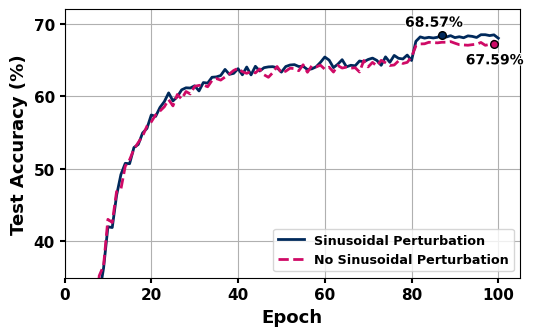

In [ ]:
########################################################################################################################
####-------| NOTE 13. SINUSOIDAL PERTUBATION VS NO SINUSOIDAL PERTUBATION | XXX --------------------####################
########################################################################################################################



import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patheffects as path_effects
import os

def read_test_log(file_path):
    test_loss_history = []
    test_acc_history = []
    with open(file_path, 'r') as f:
        for line in f:
            if "Test Loss" in line and "Test Acc" in line:
                try:
                    loss = float(line.split("Test Loss:")[1].split("|")[0].strip())
                    acc = float(line.split("Test Acc:")[1].split("%")[0].strip())
                    test_loss_history.append(loss)
                    test_acc_history.append(acc)
                except:
                    continue
    return test_loss_history, test_acc_history

def plot_train_test_metrics(save_dir="./Results/Plots"):
    os.makedirs(save_dir, exist_ok=True)



    SinPertubation_test_log_path = f'./Results_SinPertubation/CIFAR100_Test_B{bs}_LR{lr}_{net1}_{optimizer1}.txt'
    noSinPertubation_test_log_path = f'./Results/CIFAR100_Test_{sinPertubation_mode}_B{bs}_LR{lr}_{net1}_{optimizer1}.txt'


    SinPertubation_test_loss, SinPertubation_test_acc = read_test_log(SinPertubation_test_log_path)
    noSinPertubation_test_loss, noSinPertubation_test_acc = read_test_log(noSinPertubation_test_log_path)

    num_epochs = min(len(SinPertubation_test_loss), len(noSinPertubation_test_loss))
    epochs = range(1, num_epochs + 1)

    COLOR_SCALE = ['#00295B', '#CF0A66']  # SinPertubation, noSinPertubation
    rcParams.update({
        "font.size": 11,
        "axes.titlesize": 11,
        "axes.labelsize": 13,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "axes.labelweight": "bold",
        "xtick.color": "black",
        "ytick.color": "black",
    })

    # Custom settings
    custom_yticks_test_loss = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
    custom_yticks_test_acc = [10, 20, 30, 40, 50, 60, 70]
    custom_xticks = [0, 20, 40, 60, 80, 100]
    custom_yaxis_test_loss = [1.2, 4.2]
    custom_yaxis_test_acc = [35, 72]
    custom_xaxis = [0, 105]

    # Offsets
    y_offset_loss_tp = 0.2
    y_offset_loss_ntp = 0.07
    x_offset_loss_tp = 3.5
    x_offset_loss_ntp = 3.5

    y_offset_acc_tp = 1
    y_offset_acc_ntp = 3.2
    x_offset_acc_tp = 8.5
    x_offset_acc_ntp = 6.5

    # 🔷 Plot Test Loss
    fig1, ax1 = plt.subplots(figsize=(5.5, 3.5))
    ax1.plot(epochs, SinPertubation_test_loss[:num_epochs], label="Sinusoidal Perturbation", color=COLOR_SCALE[0], linewidth=2)
    ax1.plot(epochs, noSinPertubation_test_loss[:num_epochs], label="No Sinusoidal Perturbation", color=COLOR_SCALE[1], linestyle='--', linewidth=2)
    ax1.set_xlabel("Epoch", fontweight='bold')
    ax1.set_ylabel("Test Loss", fontweight='bold')
    ax1.set_xticks(custom_xticks)
    ax1.set_yticks(custom_yticks_test_loss)
    ax1.set_xlim(custom_xaxis)
    ax1.set_ylim(custom_yaxis_test_loss)
    ax1.tick_params(axis='x', width=1.5)
    ax1.tick_params(axis='y', width=1.5)
    for label in ax1.get_xticklabels() + ax1.get_yticklabels():
        label.set_fontweight('bold')
    leg1 = ax1.legend(fontsize='small', loc="upper right")
    for text in leg1.get_texts():
        text.set_fontweight('bold')
    ax1.grid(True)

    # Add final loss markers
    ax1.plot(epochs[-1], SinPertubation_test_loss[-1], marker='o', color=COLOR_SCALE[0], markersize=4)
    ax1.text(epochs[-1] - x_offset_loss_tp, SinPertubation_test_loss[-1] - y_offset_loss_tp,
             f"{SinPertubation_test_loss[-1]:.2f}", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])
    ax1.plot(epochs[-1], noSinPertubation_test_loss[-1], marker='o', color=COLOR_SCALE[1], markersize=4)
    ax1.text(epochs[-1] - x_offset_loss_ntp, noSinPertubation_test_loss[-1] + y_offset_loss_ntp,
             f"{noSinPertubation_test_loss[-1]:.2f}", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "compare_test_loss_sinPertubation_vs_no_sinPertubation.svg"),
                format='svg', transparent=True, bbox_inches='tight')
    plt.close(fig1)

    # 🔶 Plot Test Accuracy
    best_epoch_tp = SinPertubation_test_acc.index(max(SinPertubation_test_acc)) + 1
    best_acc_tp = max(SinPertubation_test_acc)
    best_epoch_ntp = noSinPertubation_test_acc.index(max(noSinPertubation_test_acc)) + 1
    best_acc_ntp = max(noSinPertubation_test_acc)

    fig2, ax2 = plt.subplots(figsize=(5.5, 3.5))
    ax2.plot(epochs, SinPertubation_test_acc[:num_epochs], label="Sinusoidal Perturbation", color=COLOR_SCALE[0], linewidth=2)
    ax2.plot(epochs, noSinPertubation_test_acc[:num_epochs], label="No Sinusoidal Perturbation", color=COLOR_SCALE[1], linestyle='--', linewidth=2)
    ax2.set_xlabel("Epoch", fontweight='bold')
    ax2.set_ylabel("Test Accuracy (%)", fontweight='bold')
    ax2.set_xticks(custom_xticks)
    ax2.set_yticks(custom_yticks_test_acc)
    ax2.set_xlim(custom_xaxis)
    ax2.set_ylim(custom_yaxis_test_acc)
    ax2.tick_params(axis='x', width=1.5)
    ax2.tick_params(axis='y', width=1.5)
    for label in ax2.get_xticklabels() + ax2.get_yticklabels():
        label.set_fontweight('bold')
    leg2 = ax2.legend(fontsize='small', loc="lower right")
    for text in leg2.get_texts():
        text.set_fontweight('bold')
    ax2.grid(True)

    # Markers for best accuracy
    ax2.plot(best_epoch_tp, best_acc_tp - 0.21, marker='o', color=COLOR_SCALE[0], markersize=5.5, markeredgecolor='black', markeredgewidth=1)
    ax2.text(best_epoch_tp - x_offset_acc_tp, best_acc_tp + y_offset_acc_tp,
             f"{best_acc_tp:.2f}%", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])
    ax2.plot(best_epoch_ntp, best_acc_ntp - 0.4, marker='o', color=COLOR_SCALE[1], markersize=5.5, markeredgecolor='black', markeredgewidth=1)
    ax2.text(best_epoch_ntp - x_offset_acc_ntp, best_acc_ntp - y_offset_acc_ntp,
             f"{best_acc_ntp:.2f}%", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "compare_test_accuracy_sinPertubation_vs_no_sinPertubation.svg"),
                format='svg', transparent=True, bbox_inches='tight')
    # plt.close(fig2)

    return f"✅ Annotated comparison plots with BEST accuracy markers saved to {save_dir}"

# 🔷 Call the function
plot_train_test_metrics()